# GDELT Events Regression

This script will preprocess GDELT events data for Ukraine and run a regression with the
data provided from UNHCR

Author(s): Aidan Pizzo \
Last updated: March 17, 2023

In [1]:
import math
import pandas as pd
import statsmodels.api as sm
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta

### Data Processing

In [2]:
BASE_DIR = ''
GDELT_DATA_PATH = './data/gdelt_vars_without_oblast.csv'
UNHCR_DATA_PATH = './data/ukraine_displaced.csv'
OBLAST_MAP_PATH = '../../UkraineOblasts.csv'

gdelt_df = pd.read_csv(BASE_DIR+GDELT_DATA_PATH)
unhcr_df = pd.read_csv(BASE_DIR+UNHCR_DATA_PATH, )
oblast_map = pd.read_csv(BASE_DIR+OBLAST_MAP_PATH)

In [3]:
# Create dictionary to map oblast code to macroregion
oblastCodeToRegion = dict(zip(oblast_map['key'], oblast_map['macroregion']))
gdelt_df['Macro-region'] = gdelt_df['ActionGeo_ADM1Code'].apply(lambda x: oblastCodeToRegion[x])

# Drop rows with 'UP' and 'UP00' (data with no spatial granularity), as well as the macroregion Crimea
ind = gdelt_df[(gdelt_df['ActionGeo_ADM1Code'] == 'UP') | (gdelt_df['ActionGeo_ADM1Code'] == 'UP00')].index
gdelt_df.drop(ind, inplace=True)
ind = gdelt_df[(gdelt_df['Macro-region'] == 'Crimea')].index
gdelt_df.drop(ind, inplace=True)

# convert SQLDATE to datetime and drop SQLDATE column
gdelt_df['date'] = pd.to_datetime(gdelt_df.loc[:, 'SQLDATE'], format="%Y%m%d")
gdelt_df = gdelt_df.drop(['SQLDATE'], axis=1)

# convert dates in UNHCR dataframe
unhcr_df['date_to'] = pd.to_datetime(unhcr_df['date_to'])
unhcr_df['date_from'] = pd.to_datetime(unhcr_df['date_from'])

# Drop extra index column 'Unnamed: 0'
unhcr_df = unhcr_df.drop(['Unnamed: 0'], axis=1)

In [4]:
# Aggregate macroregions, sum variable values
gdelt_df.groupby(['Macro-region', 'date']).sum()

NumEvents  NumEvents_VerbalCooperation  \
Macro-region date                                                 
Center       2022-02-01         51                           33   
             2022-02-02         36                           15   
             2022-02-03         29                           12   
             2022-02-04         24                           13   
             2022-02-05          3                            1   
...                            ...                          ...   
West         2023-01-09        155                           84   
             2023-01-10        126                           59   
             2023-01-11        770                          578   
             2023-01-12        495                          326   
             2023-01-13        251                          140   

                         NumEvents_MateriallCooperation  \
Macro-region date                                         
Center       2022-02-01                               4   
             2022-02-02                               6   
             2022-02-03                               6   
             2022-02-04                               6   
             2022-02-05                               1   
...                                                 ...   
West         2023-01-09                              22   
             2023-01-10                              24   
             2023-01-11                              85   
             2023-01-12                              67   
             2023-01-13                              38   

                         NumEvents_VerbalConflict  NumEvents_MaterialConflict  \
Macro-region date                                                               
Center       2022-02-01                         6                           8   
             2022-02-02                         8                           7   
             2022-02-03                         5                           6   
             2022-02-04                         2                           3   
             2022-02-05                         1                           0   
...                                           ...                         ...   
West         2023-01-09                        25                          24   
             2023-01-10                        21                          22   
             2023-01-11                        34                          73   
             2023-01-12                        48                          54   
             2023-01-13                        31                          42   

                         absGoldstein  totalNegGoldstein  totalPosGoldstein  \
Macro-region date                                                             
Center       2022-02-01         211.8              -86.5              125.3   
             2022-02-02         168.1              -90.0               78.1   
             2022-02-03         129.5              -75.9               53.6   
             2022-02-04          72.7              -36.0               36.7   
             2022-02-05           5.9               -4.0                1.9   
...                               ...                ...                ...   
West         2023-01-09         612.1             -303.8              308.3   
             2023-01-10         551.4             -263.4              288.0   
             2023-01-11        3080.3             -759.2             2321.1   
             2023-01-12        2067.7             -675.7             1392.0   
             2023-01-13        1240.5             -533.0              707.5   

                          absAvgTone  totalPosTone  totalNegTone  
Macro-region date                                                 
Center       2022-02-01   179.529599     22.499665   -157.029933  
             2022-02-02   174.520380      3.176187   -171.344193  
             2022-02-03   127.96076

In [5]:
# Aggregate over time periods from UNHCR data
intervals = unhcr_df[['date_from', 'date_to', 'period_length']].drop_duplicates()
# Create empty data frame with column names to add date-aggregated data
final_df = pd.DataFrame(columns=['Macro-region',
                                 'NumEvents',
                                 'NumEvents_VerbalCooperation',
                                 'NumEvents_MateriallCooperation',
                                 'NumEvents_VerbalConflict',
                                 'NumEvents_MaterialConflict',
                                 'absGoldstein',
                                 'totalNegGoldstein',
                                 'totalPosGoldstein',
                                 'absAvgTone',
                                 'totalPosTone',
                                 'totalNegTone', ])

"""
Create list of tuple date ranges,
iterate through each of the date ranges and create a dataframe containing data in that range,
aggregate data across dates, taking mean of all variables values while grouping by Macro-region,
add date-aggregated to final dataframe
"""
ranges = list(intervals.itertuples(index=False, name=None))
for drange in ranges:
    events_date_range = gdelt_df[(gdelt_df['date'] >= drange[0]) & (gdelt_df['date'] < drange[1])]
    events_date_range = events_date_range.groupby('Macro-region').mean()
    events_date_range = events_date_range.reset_index()
    events_date_range['date_from'] = drange[0]
    events_date_range['date_to'] = drange[1]
    frames = [final_df, events_date_range]
    final_df = pd.concat(frames)

In [6]:
# Make Multi-index before running regression (Macro-region and date_to)
final_df.index = final_df['Macro-region'] + '-' + final_df['date_to'].astype(str)
unhcr_df.index = unhcr_df['Macro-region'] + '-' + unhcr_df['date_to'].astype(str)

In [7]:
# print(final_df.head)
# print(unhcr_df.head)
final_df.drop(['date_to', 'date_from', 'Macro-region'], axis=1).to_csv('gdelt_events_vars.csv')

### Exploratory Data Analysis

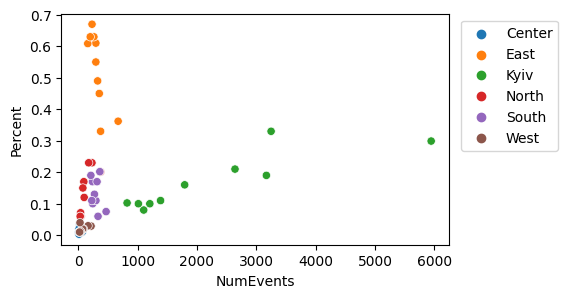

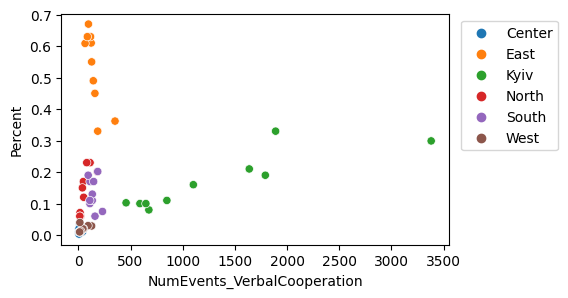

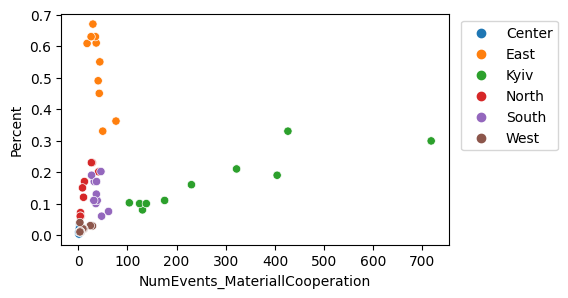

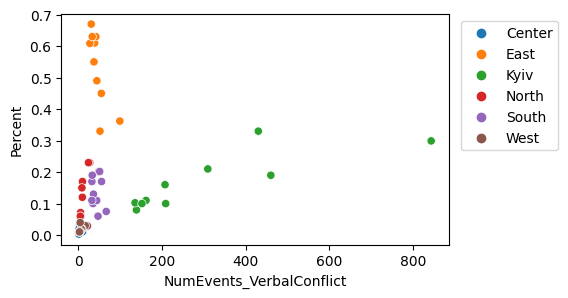

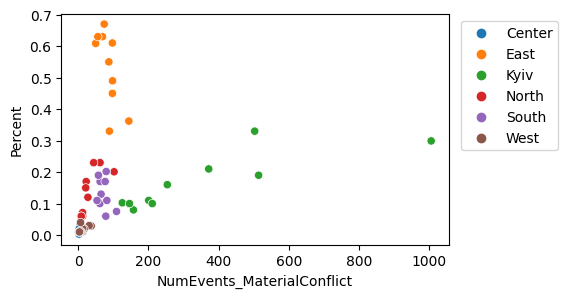

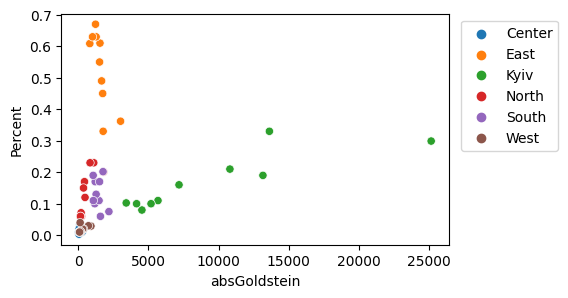

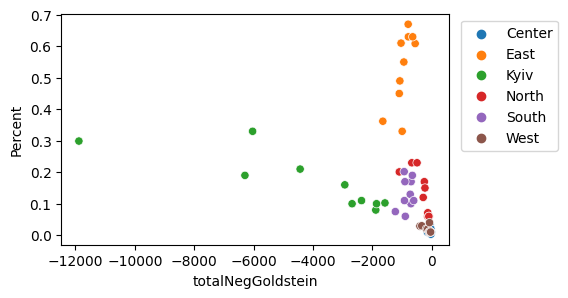

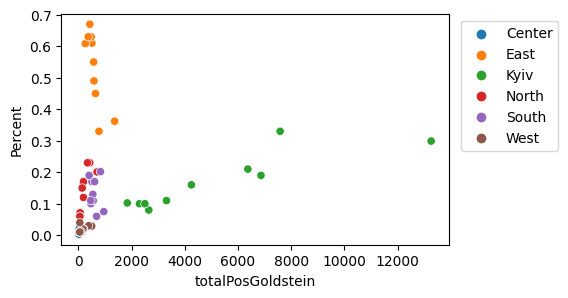

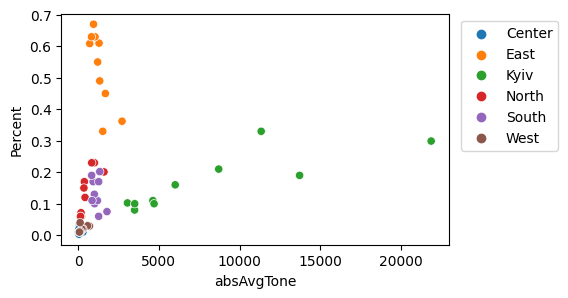

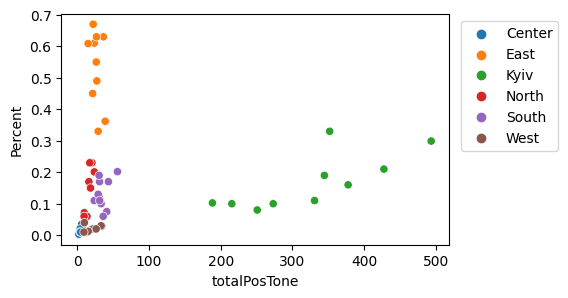

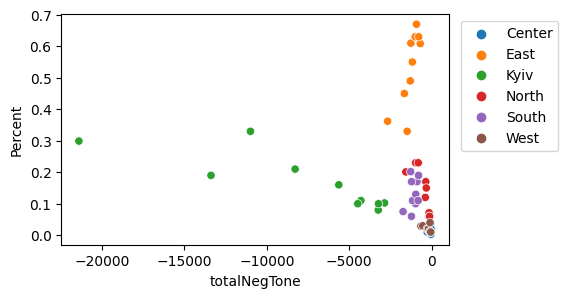

In [8]:
# variable values vs the flow percentage
for column in final_df.columns[1:12]:
    plt.figure(figsize=(5,3))
    sns.scatterplot(x=final_df[column], y=unhcr_df['Percent'], hue=unhcr_df['Macro-region'])
    plt.legend(bbox_to_anchor=(1.3, 1), loc='upper right')
    #plt.plot(final_df[column], unhcr_df['Percent'])

NumEvents

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.004
Model:                            OLS   Adj. R-squared:                 -0.014
Method:                 Least Squares   F-statistic:                    0.2112
Date:                Wed, 12 Apr 2023   Prob (F-statistic):              0.648
Time:                        09:46:28   Log-Likelihood:                 15.826
No. Observations:                  60   AIC:                            -27.65
Df Residuals:                      58   BIC:                            -23.46
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.1728      0.027      6.2

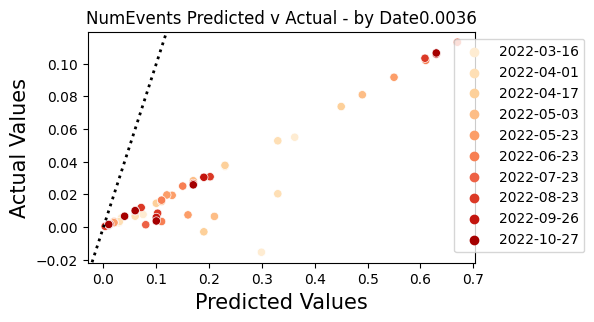

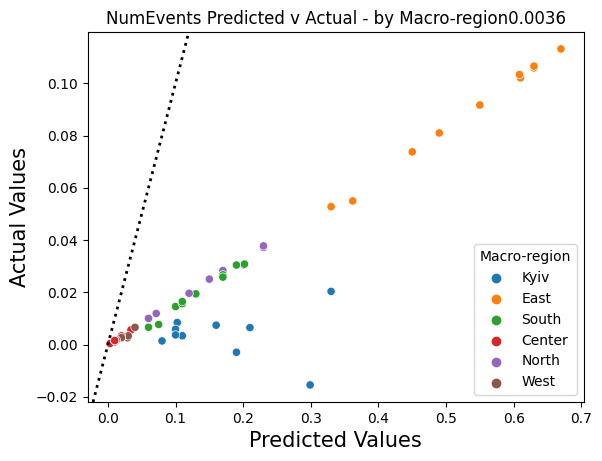




NumEvents_VerbalCooperation

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.006
Model:                            OLS   Adj. R-squared:                 -0.011
Method:                 Least Squares   F-statistic:                    0.3598
Date:                Wed, 12 Apr 2023   Prob (F-statistic):              0.551
Time:                        09:46:29   Log-Likelihood:                 15.902
No. Observations:                  60   AIC:                            -27.80
Df Residuals:                      58   BIC:                            -23.62
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.174

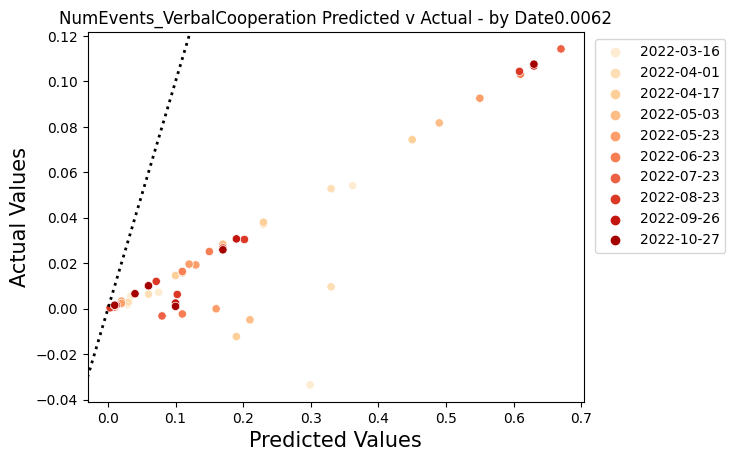

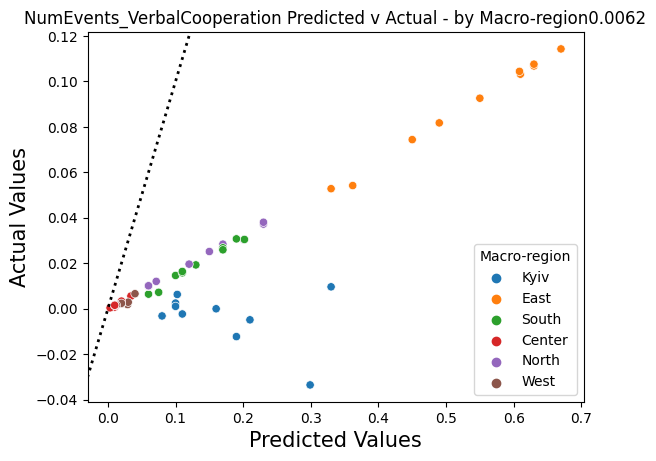




NumEvents_MateriallCooperation

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.004
Model:                            OLS   Adj. R-squared:                 -0.014
Method:                 Least Squares   F-statistic:                    0.2093
Date:                Wed, 12 Apr 2023   Prob (F-statistic):              0.649
Time:                        09:46:30   Log-Likelihood:                 15.825
No. Observations:                  60   AIC:                            -27.65
Df Residuals:                      58   BIC:                            -23.46
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.

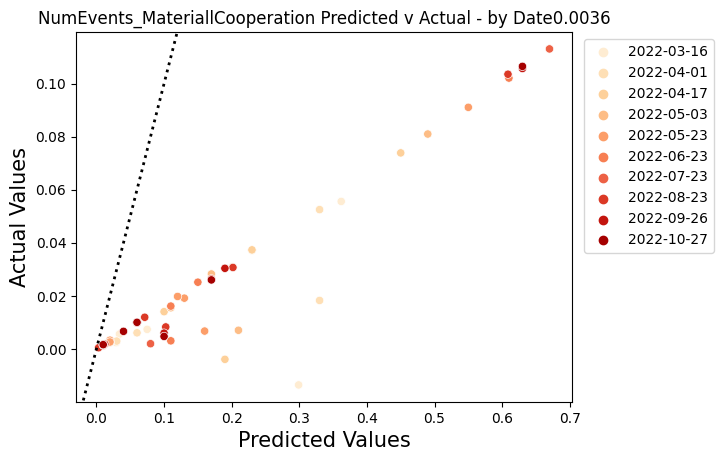

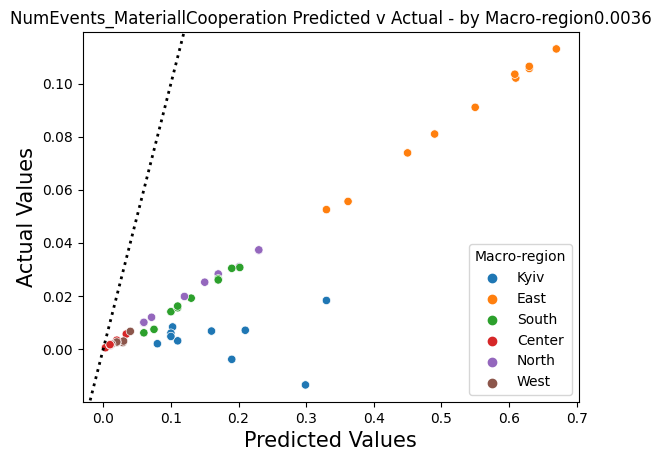




NumEvents_VerbalConflict

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.002
Model:                            OLS   Adj. R-squared:                 -0.015
Method:                 Least Squares   F-statistic:                    0.1356
Date:                Wed, 12 Apr 2023   Prob (F-statistic):              0.714
Time:                        09:46:31   Log-Likelihood:                 15.787
No. Observations:                  60   AIC:                            -27.57
Df Residuals:                      58   BIC:                            -23.38
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.1716  

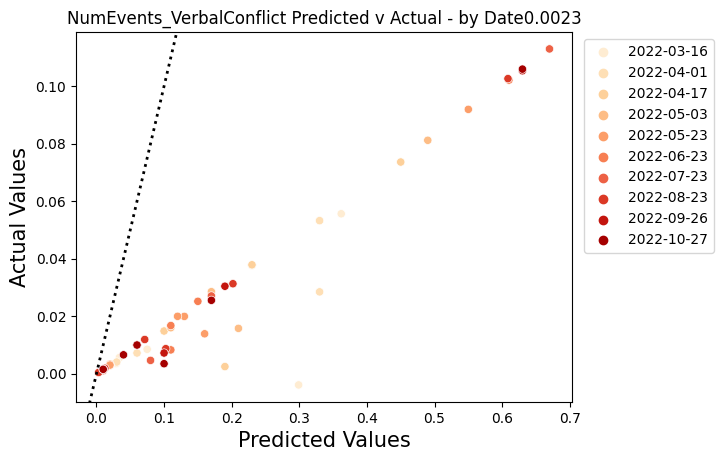

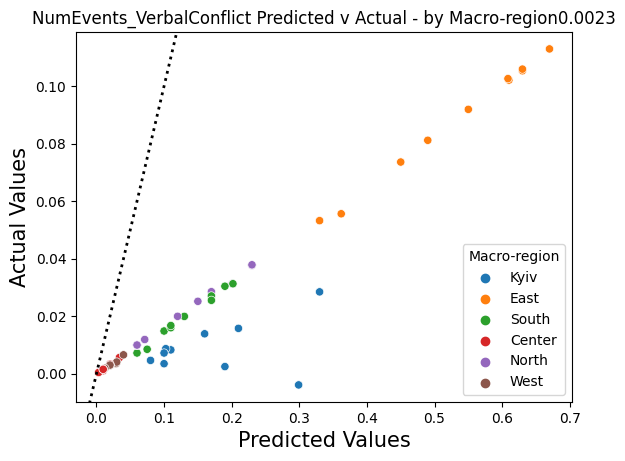




NumEvents_MaterialConflict

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                 -0.017
Method:                 Least Squares   F-statistic:                 0.0006678
Date:                Wed, 12 Apr 2023   Prob (F-statistic):              0.979
Time:                        09:46:31   Log-Likelihood:                 15.717
No. Observations:                  60   AIC:                            -27.43
Df Residuals:                      58   BIC:                            -23.25
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.1674

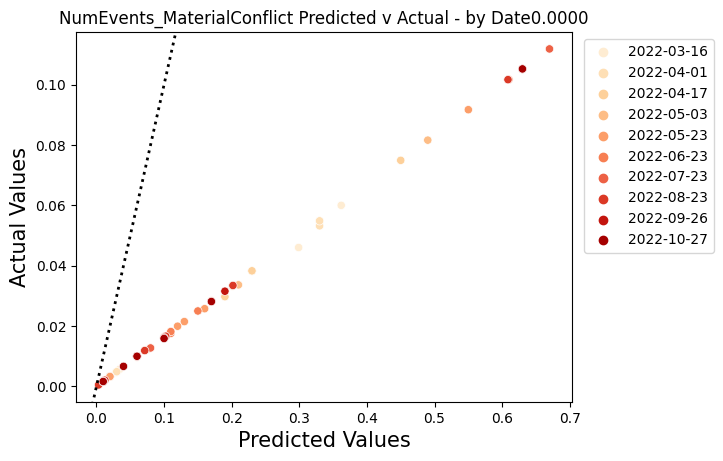

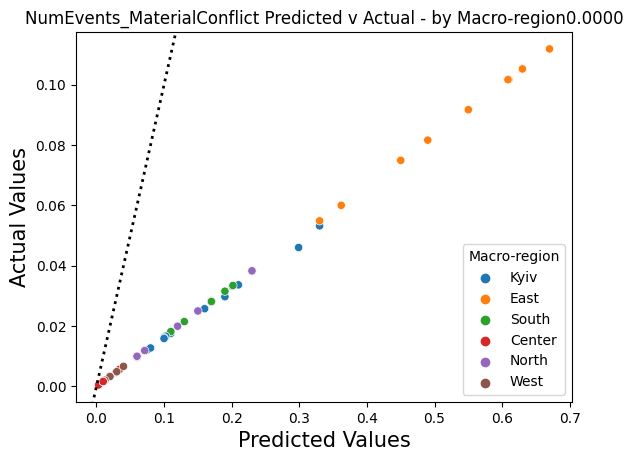




absGoldstein

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.002
Model:                            OLS   Adj. R-squared:                 -0.015
Method:                 Least Squares   F-statistic:                    0.1229
Date:                Wed, 12 Apr 2023   Prob (F-statistic):              0.727
Time:                        09:46:33   Log-Likelihood:                 15.780
No. Observations:                  60   AIC:                            -27.56
Df Residuals:                      58   BIC:                            -23.37
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.1716      0.028   

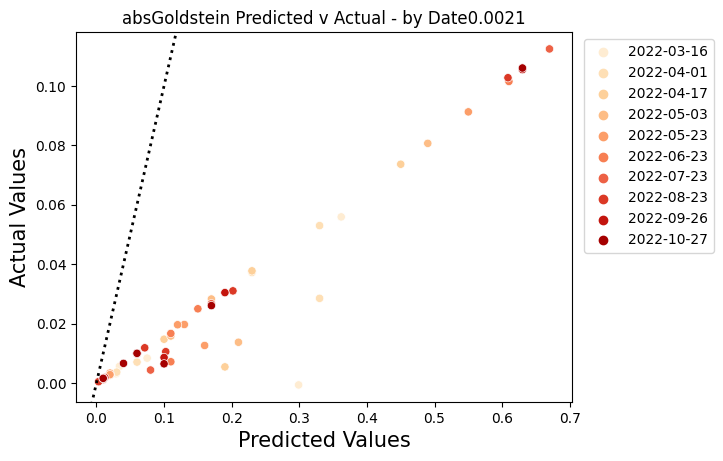

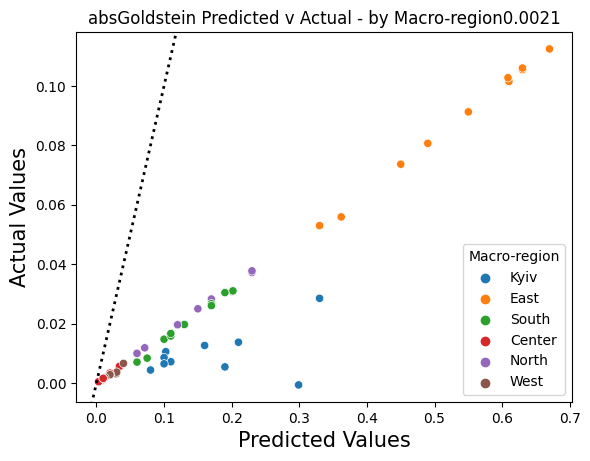




totalNegGoldstein

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                 -0.017
Method:                 Least Squares   F-statistic:                  0.007378
Date:                Wed, 12 Apr 2023   Prob (F-statistic):              0.932
Time:                        09:46:34   Log-Likelihood:                 15.720
No. Observations:                  60   AIC:                            -27.44
Df Residuals:                      58   BIC:                            -23.25
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.1682      0.0

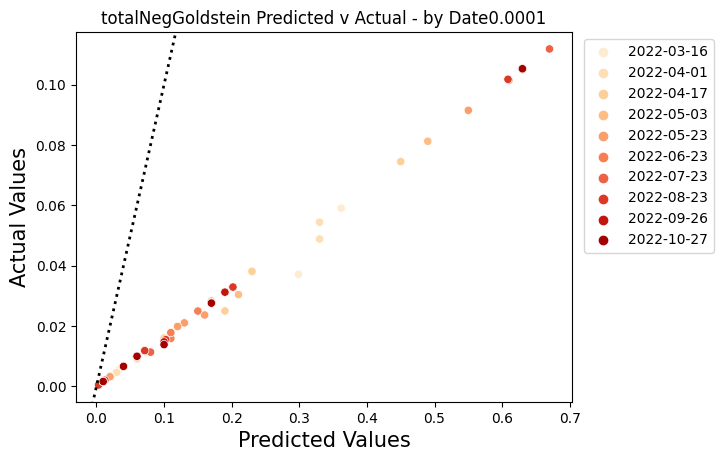

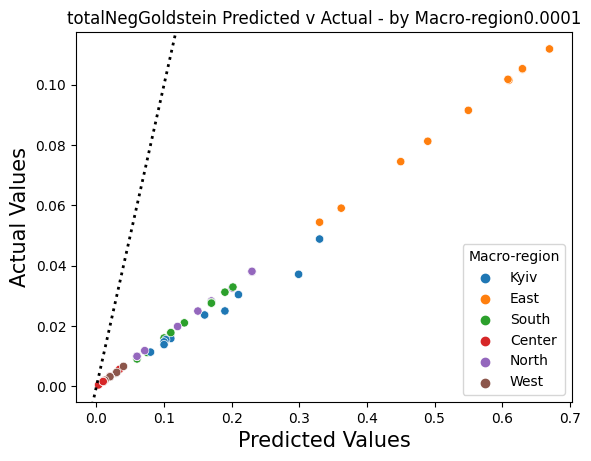




totalPosGoldstein

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.006
Model:                            OLS   Adj. R-squared:                 -0.012
Method:                 Least Squares   F-statistic:                    0.3275
Date:                Wed, 12 Apr 2023   Prob (F-statistic):              0.569
Time:                        09:46:35   Log-Likelihood:                 15.885
No. Observations:                  60   AIC:                            -27.77
Df Residuals:                      58   BIC:                            -23.58
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.1740      0.0

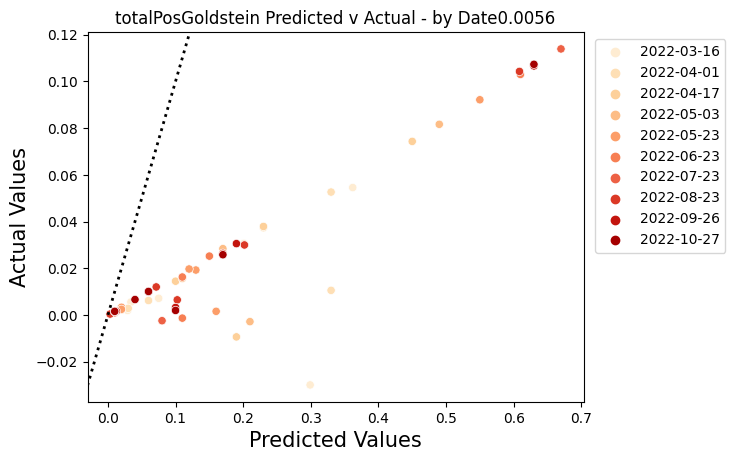

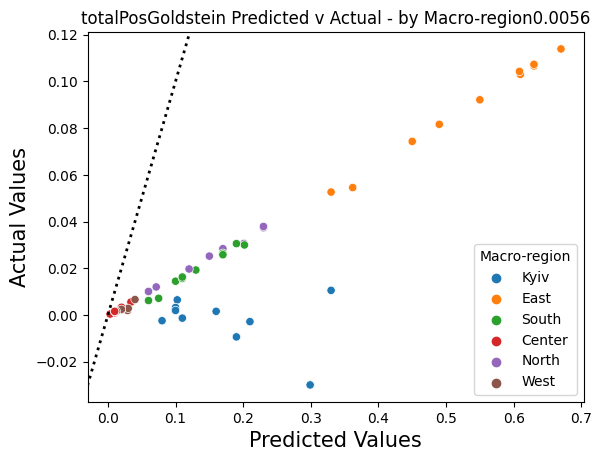




absAvgTone

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.002
Model:                            OLS   Adj. R-squared:                 -0.015
Method:                 Least Squares   F-statistic:                    0.1394
Date:                Wed, 12 Apr 2023   Prob (F-statistic):              0.710
Time:                        09:46:36   Log-Likelihood:                 15.789
No. Observations:                  60   AIC:                            -27.58
Df Residuals:                      58   BIC:                            -23.39
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.1717      0.028     

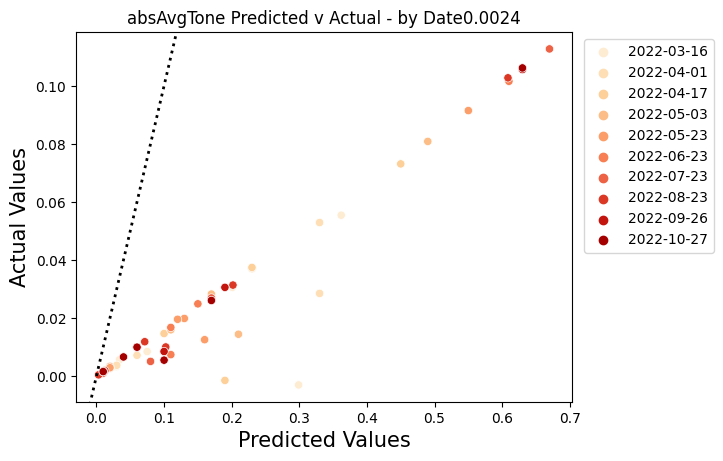

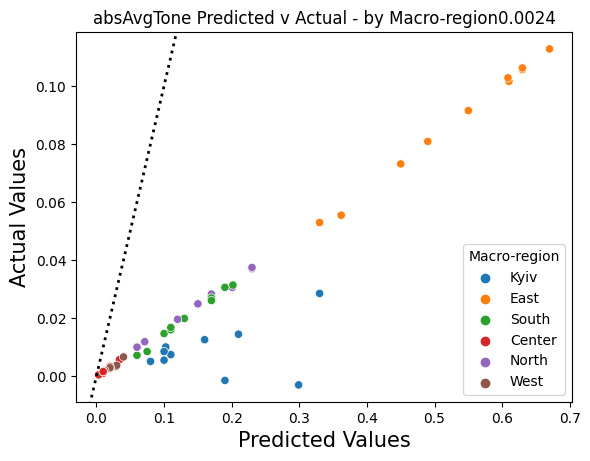




totalPosTone

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.008
Model:                            OLS   Adj. R-squared:                 -0.009
Method:                 Least Squares   F-statistic:                    0.4799
Date:                Wed, 12 Apr 2023   Prob (F-statistic):              0.491
Time:                        09:46:36   Log-Likelihood:                 15.964
No. Observations:                  60   AIC:                            -27.93
Df Residuals:                      58   BIC:                            -23.74
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.1771      0.028   

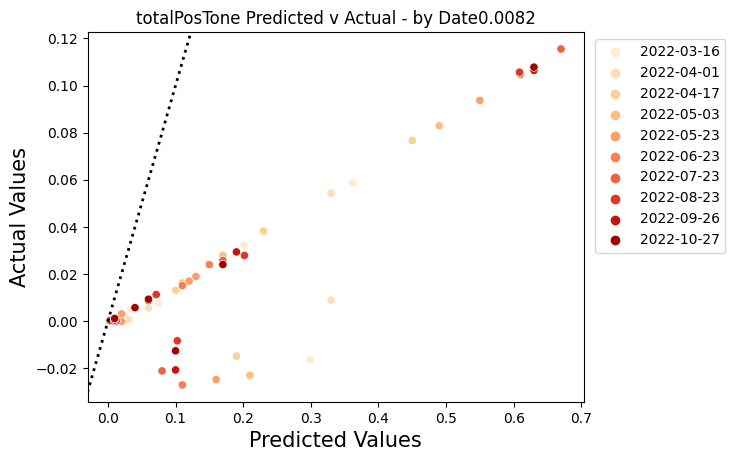

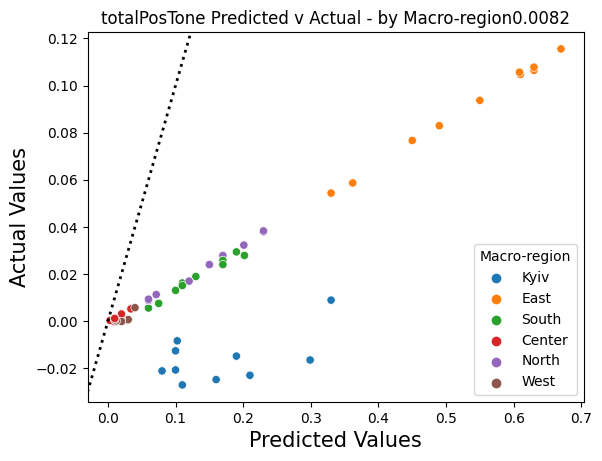




totalNegTone

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.002
Model:                            OLS   Adj. R-squared:                 -0.015
Method:                 Least Squares   F-statistic:                    0.1304
Date:                Wed, 12 Apr 2023   Prob (F-statistic):              0.719
Time:                        09:46:37   Log-Likelihood:                 15.784
No. Observations:                  60   AIC:                            -27.57
Df Residuals:                      58   BIC:                            -23.38
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.1715      0.027   

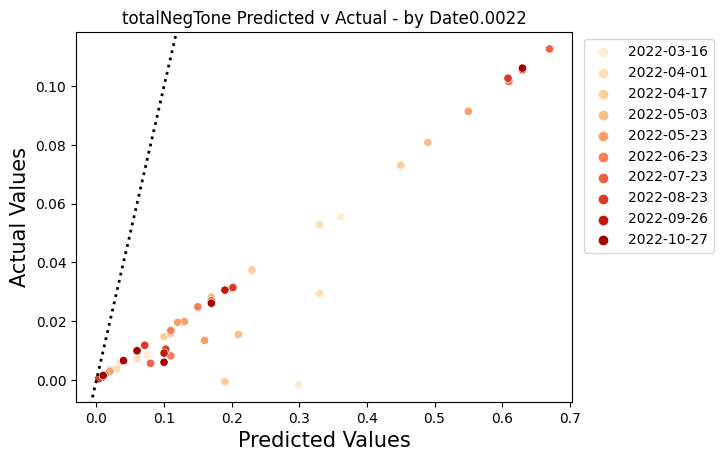

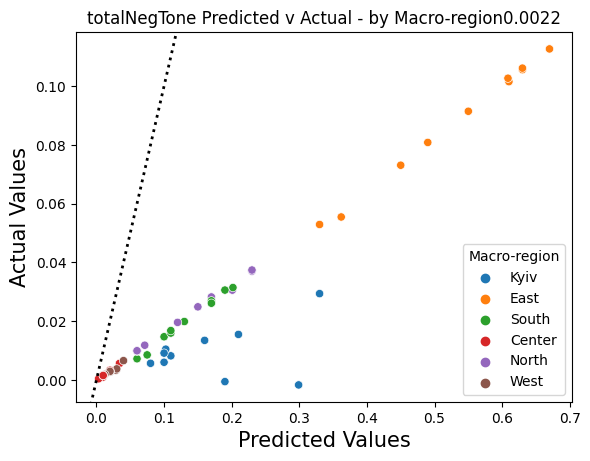

In [9]:
# build regression model for each GDELT events variable
plt.figure(figsize=(5,3))
for column in final_df.columns[1:12]:
    Y = unhcr_df['Percent']
    X = final_df[column]
    model = sm.OLS(np.array(Y.astype(float)), sm.add_constant(np.array(X.astype(float))))
    fit = model.fit()
    print(column + "\n")
    print(fit.summary())
    print("\n")
    print('R-squared: ', fit.rsquared)
    print("\n")
    
    # predictions vs actual values plot, colored by date
    predictions = fit.predict(pd.concat([unhcr_df['Percent'], final_df[column]], axis=1))
    plt.title(column + " Predicted v Actual - by Date" + str('%.4f'%(fit.rsquared)))
    plt.xlabel('Predicted Values', fontsize=15)
    plt.ylabel('Actual Values', fontsize=15)
    sns.scatterplot(x=unhcr_df['Percent'], y=predictions, hue=unhcr_df['date_to'].dt.date, palette='OrRd') # add style=unhcr_df['Macro-region'] for shape by Macro-region or vice versa
    plt.legend(bbox_to_anchor=(1.3, 1), loc='upper right')
    #plt.scatter(predictions, unhcr_df['Percent'], c=unhcr_df.date_to, cmap='OrRd')
    xpoints = ypoints = plt.xlim()
    plt.plot(xpoints, ypoints, linestyle = 'dotted', color='k', lw=2, scalex=False, scaley=False)
    plt.show()
    
    # predictions vs actual values plot, colored by Macro-region
    plt.title(column + " Predicted v Actual - by Macro-region" + str('%.4f'%(fit.rsquared)))
    plt.xlabel('Predicted Values', fontsize=15)
    plt.ylabel('Actual Values', fontsize=15)
    #colors = {'Kyiv':'red', 'East':'green', 'South':'blue', 'Center':'yellow', 'North':'purple', 'West':'orange'}
    #plt.scatter(predictions, unhcr_df['Percent'], c=unhcr_df['Macro-region'].map(colors))
    sns.scatterplot(x=unhcr_df['Percent'], y=predictions, hue=unhcr_df['Macro-region'])
    #plt.legend(bbox_to_anchor=(1.05, 1), loc='upper right', borderaxespad=0)
    #plt.legend(labels=unhcr_df['Macro-region'])
    xpoints = ypoints = plt.xlim()
    plt.plot(xpoints, ypoints, linestyle = 'dotted', color='k', lw=2, scalex=False, scaley=False)
    plt.show()
    
    print("\n\n")
    
#plt.savefig("predicted_actual.png")


## Log10 Transformation and Regression

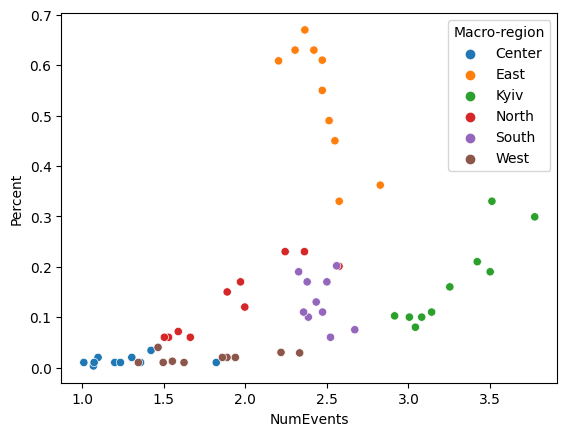

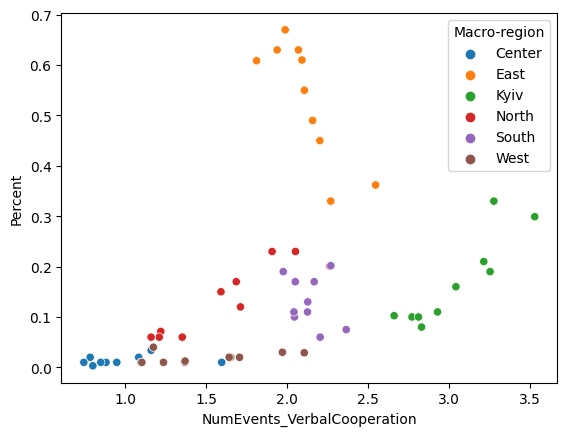

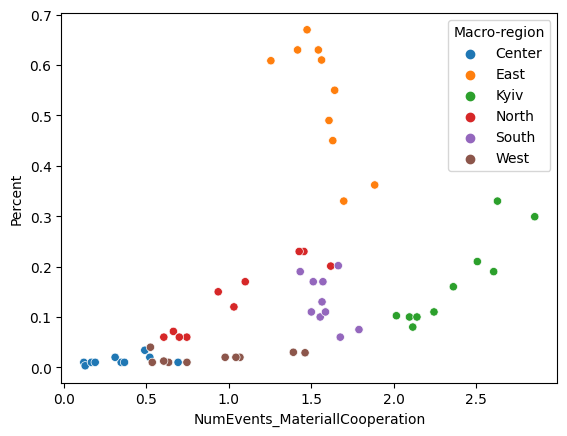

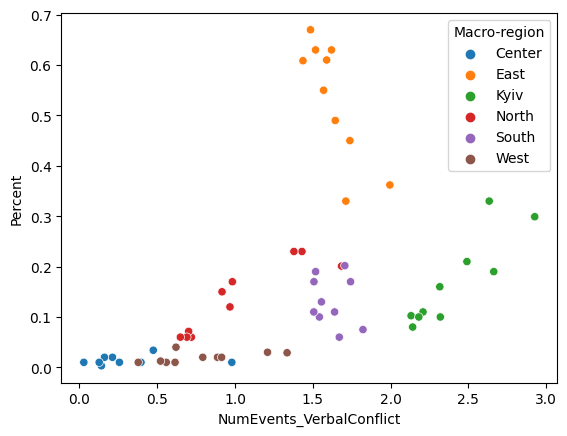

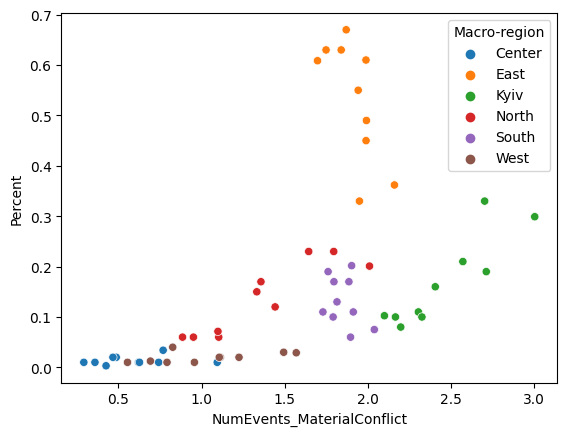

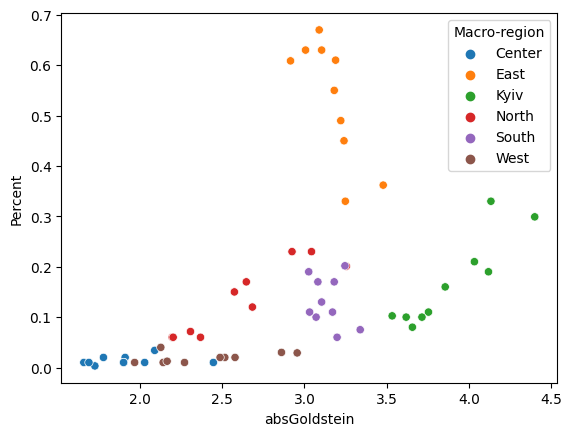

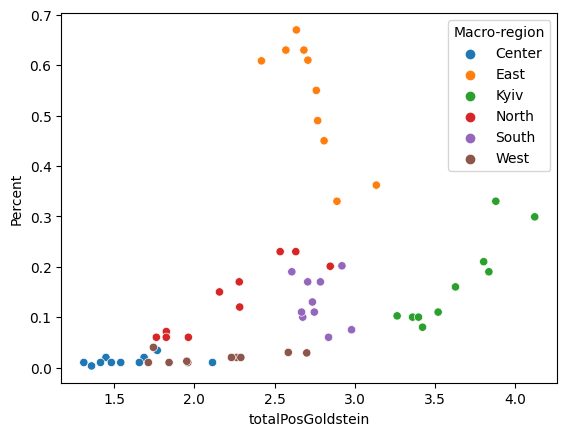

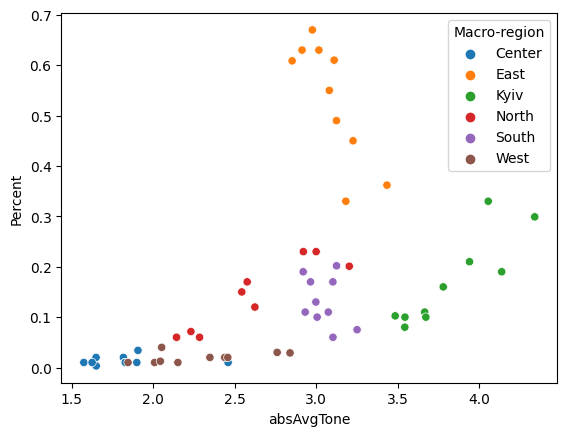

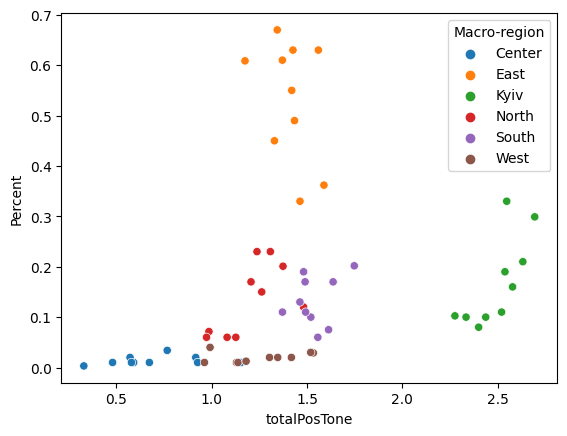

In [10]:
log_df = final_df.copy()
for column in log_df.columns[1:12]:
    if log_df[column][0] >= 0:
        log_df[column] = log_df[column].apply(lambda x: math.log10(x))
        plt.figure()
        sns.scatterplot(x=log_df[column], y=unhcr_df['Percent'], hue=unhcr_df['Macro-region'])
    else:
        log_df.drop([column], inplace=True, axis=1)

NumEvents

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.033
Model:                            OLS   Adj. R-squared:                  0.016
Method:                 Least Squares   F-statistic:                     1.974
Date:                Wed, 12 Apr 2023   Prob (F-statistic):              0.165
Time:                        09:46:43   Log-Likelihood:                 16.721
No. Observations:                  60   AIC:                            -29.44
Df Residuals:                      58   BIC:                            -25.25
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0585      0.081      0.7

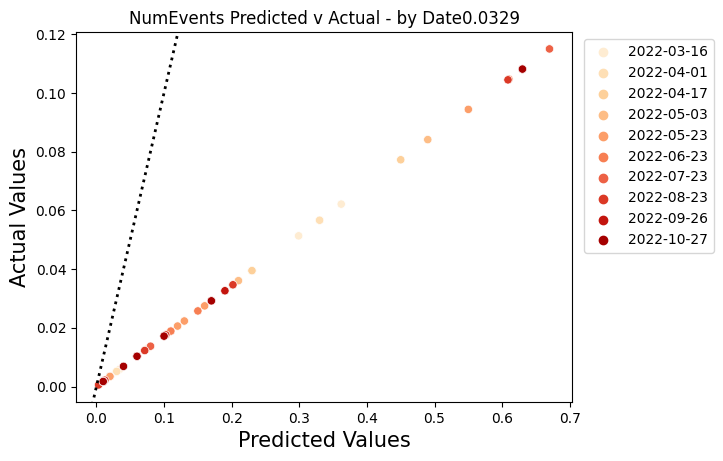

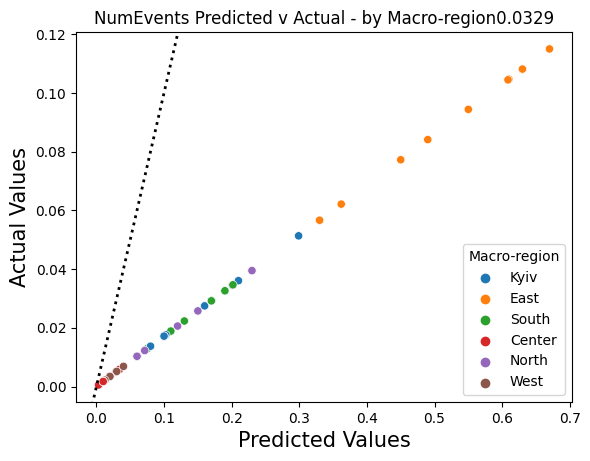







NumEvents_VerbalCooperation

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.020
Model:                            OLS   Adj. R-squared:                  0.003
Method:                 Least Squares   F-statistic:                     1.169
Date:                Wed, 12 Apr 2023   Prob (F-statistic):              0.284
Time:                        09:46:45   Log-Likelihood:                 16.315
No. Observations:                  60   AIC:                            -28.63
Df Residuals:                      58   BIC:                            -24.44
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.

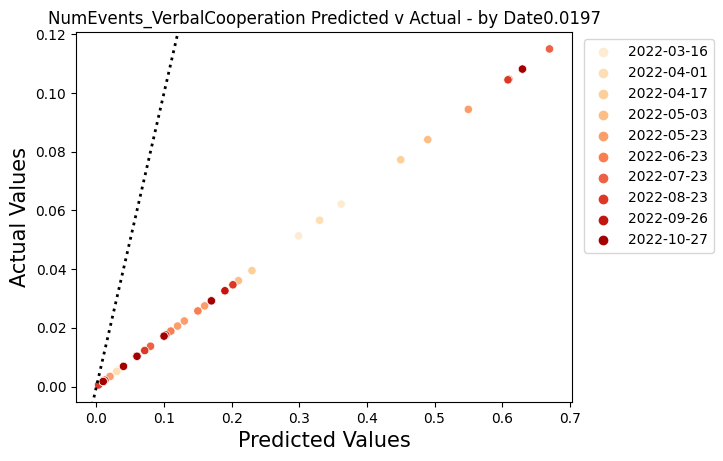

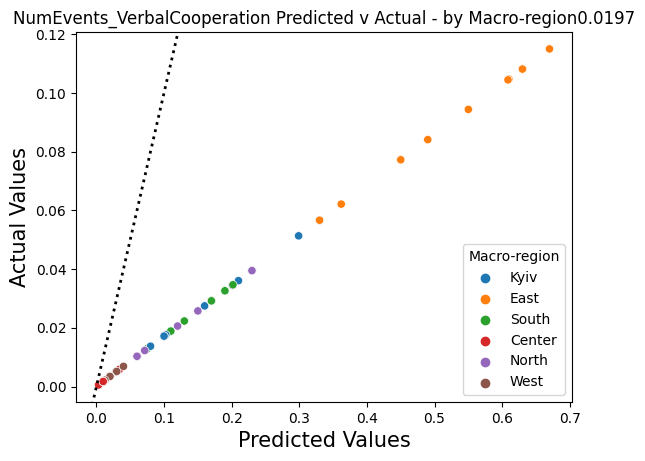







NumEvents_MateriallCooperation

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.034
Model:                            OLS   Adj. R-squared:                  0.017
Method:                 Least Squares   F-statistic:                     2.035
Date:                Wed, 12 Apr 2023   Prob (F-statistic):              0.159
Time:                        09:46:46   Log-Likelihood:                 16.751
No. Observations:                  60   AIC:                            -29.50
Df Residuals:                      58   BIC:                            -25.31
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         

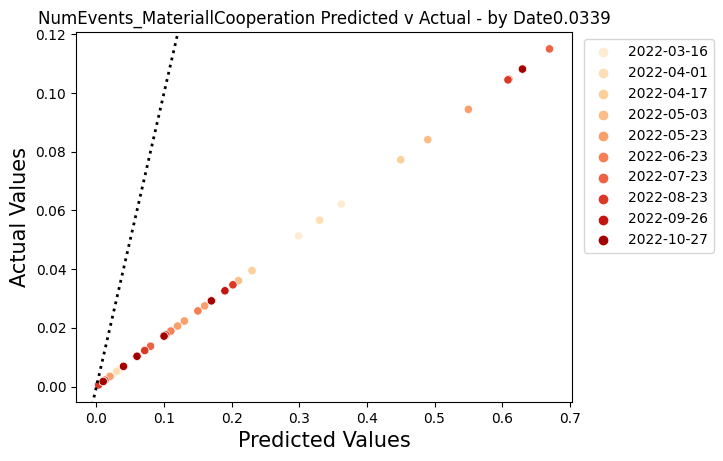

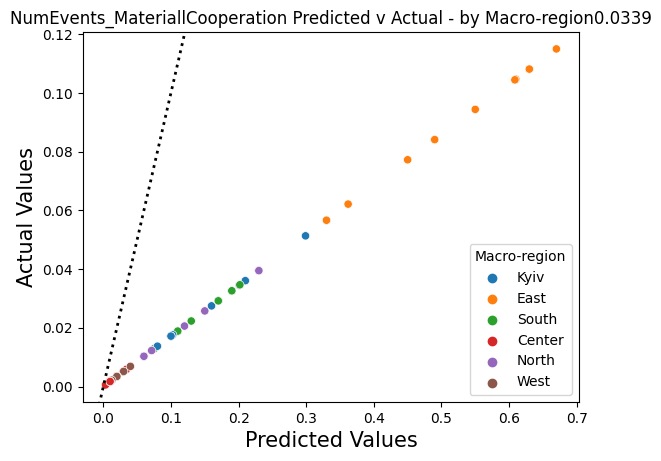







NumEvents_VerbalConflict

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.045
Model:                            OLS   Adj. R-squared:                  0.029
Method:                 Least Squares   F-statistic:                     2.740
Date:                Wed, 12 Apr 2023   Prob (F-statistic):              0.103
Time:                        09:46:47   Log-Likelihood:                 17.101
No. Observations:                  60   AIC:                            -30.20
Df Residuals:                      58   BIC:                            -26.01
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.095

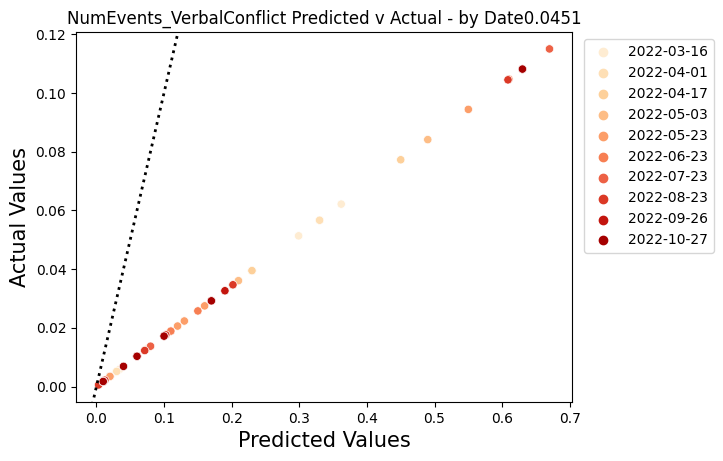

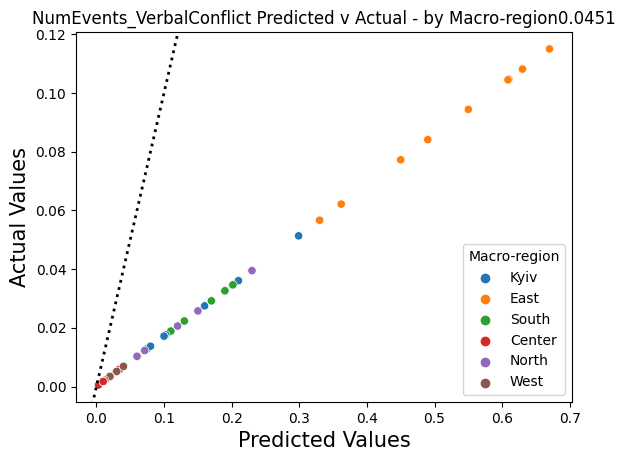







NumEvents_MaterialConflict

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.061
Model:                            OLS   Adj. R-squared:                  0.045
Method:                 Least Squares   F-statistic:                     3.787
Date:                Wed, 12 Apr 2023   Prob (F-statistic):             0.0565
Time:                        09:46:48   Log-Likelihood:                 17.614
No. Observations:                  60   AIC:                            -31.23
Df Residuals:                      58   BIC:                            -27.04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0

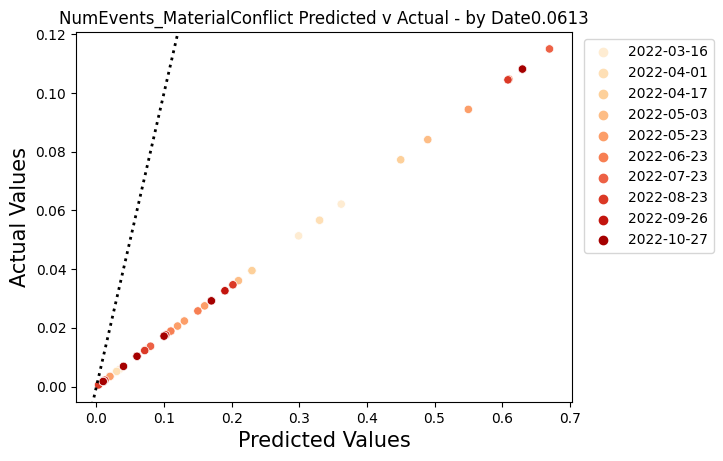

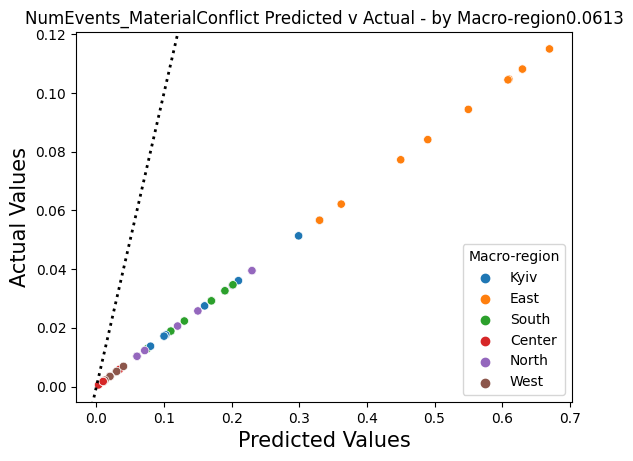







absGoldstein

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.041
Model:                            OLS   Adj. R-squared:                  0.025
Method:                 Least Squares   F-statistic:                     2.507
Date:                Wed, 12 Apr 2023   Prob (F-statistic):              0.119
Time:                        09:46:49   Log-Likelihood:                 16.986
No. Observations:                  60   AIC:                            -29.97
Df Residuals:                      58   BIC:                            -25.78
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0070      0.104

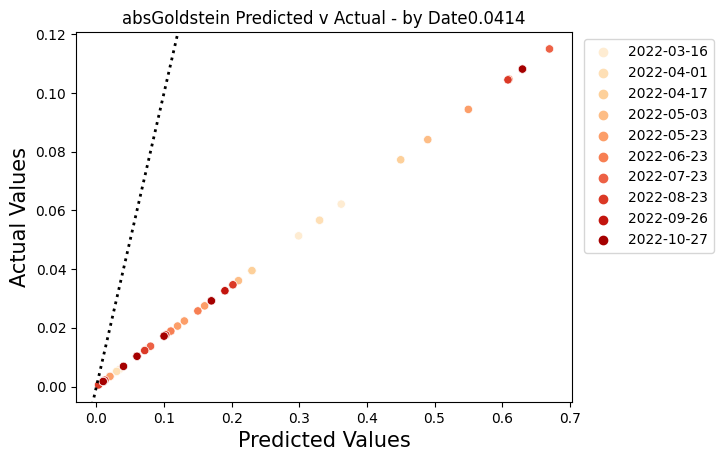

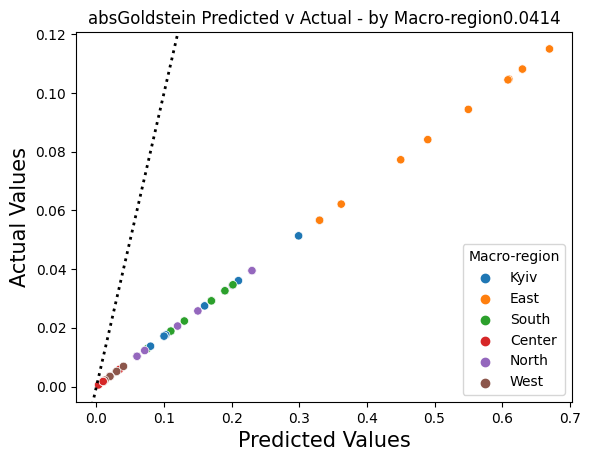







totalPosGoldstein

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.024
Model:                            OLS   Adj. R-squared:                  0.007
Method:                 Least Squares   F-statistic:                     1.401
Date:                Wed, 12 Apr 2023   Prob (F-statistic):              0.241
Time:                        09:46:50   Log-Likelihood:                 16.432
No. Observations:                  60   AIC:                            -28.86
Df Residuals:                      58   BIC:                            -24.68
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0631      

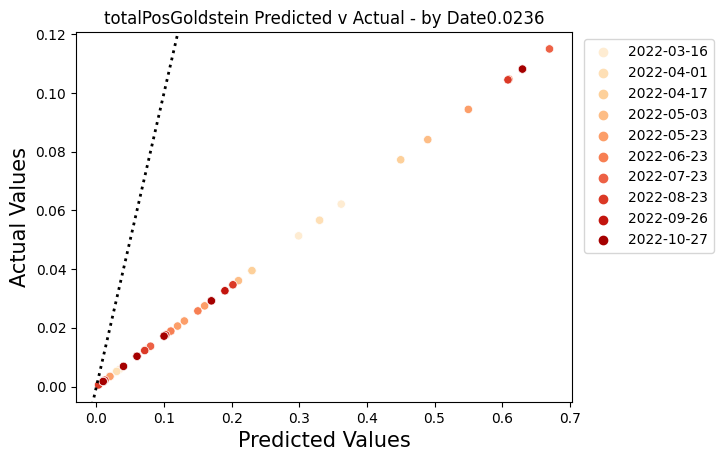

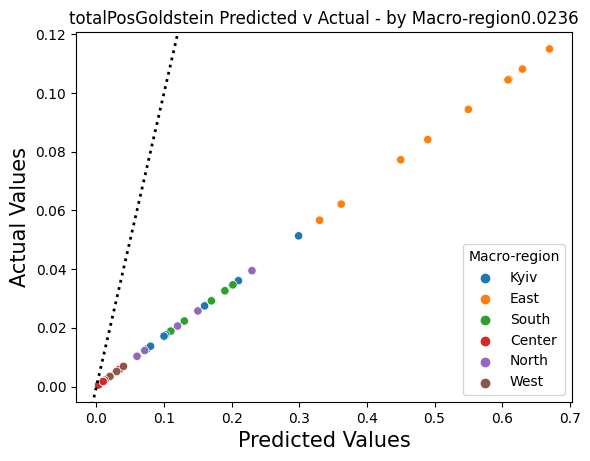







absAvgTone

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.039
Model:                            OLS   Adj. R-squared:                  0.023
Method:                 Least Squares   F-statistic:                     2.369
Date:                Wed, 12 Apr 2023   Prob (F-statistic):              0.129
Time:                        09:46:51   Log-Likelihood:                 16.917
No. Observations:                  60   AIC:                            -29.83
Df Residuals:                      58   BIC:                            -25.65
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0181      0.100  

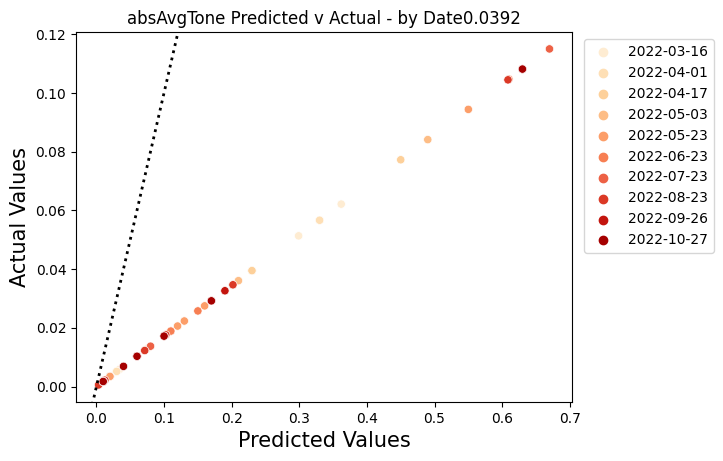

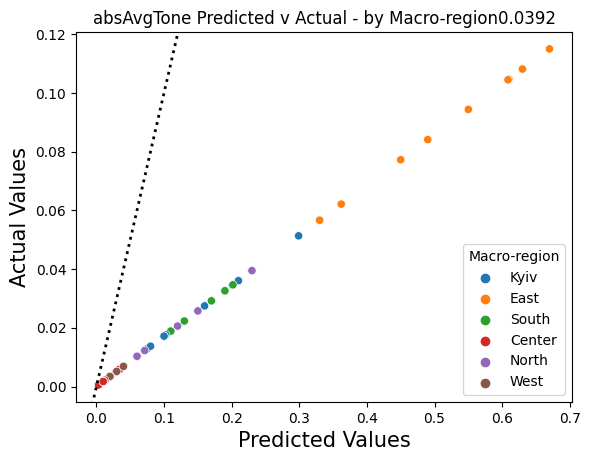

In [11]:
for column in log_df.columns[1:9]:
    model = sm.OLS(np.array(unhcr_df['Percent'].astype(float)), sm.add_constant(np.array(log_df[column].astype(float))))
    results = model.fit()
    print(column + "\n")
    print(results.summary())
    print('R-squared: ', results.rsquared)
    
    # predictions vs actual values plot, colored by date
    predictions = fit.predict(pd.concat([unhcr_df['Percent'], log_df[column]], axis=1))
    plt.title(column + " Predicted v Actual - by Date" + str('%.4f'%(results.rsquared)))
    plt.xlabel('Predicted Values', fontsize=15)
    plt.ylabel('Actual Values', fontsize=15)
    sns.scatterplot(x=unhcr_df['Percent'], y=predictions, hue=unhcr_df['date_to'].dt.date, palette='OrRd') # add style=unhcr_df['Macro-region'] for shape by Macro-region or vice versa
    plt.legend(bbox_to_anchor=(1.3, 1), loc='upper right')
    #plt.scatter(predictions, unhcr_df['Percent'], c=unhcr_df.date_to, cmap='OrRd')
    xpoints = ypoints = plt.xlim()
    plt.plot(xpoints, ypoints, linestyle = 'dotted', color='k', lw=2, scalex=False, scaley=False)
    plt.show()
    
    # predictions vs actual values plot, colored by Macro-region
    plt.title(column + " Predicted v Actual - by Macro-region" + str('%.4f'%(results.rsquared)))
    plt.xlabel('Predicted Values', fontsize=15)
    plt.ylabel('Actual Values', fontsize=15)
    #colors = {'Kyiv':'red', 'East':'green', 'South':'blue', 'Center':'yellow', 'North':'purple', 'West':'orange'}
    #plt.scatter(predictions, unhcr_df['Percent'], c=unhcr_df['Macro-region'].map(colors))
    sns.scatterplot(x=unhcr_df['Percent'], y=predictions, hue=unhcr_df['Macro-region'])
    #plt.legend(bbox_to_anchor=(1.05, 1), loc='upper right', borderaxespad=0)
    #plt.legend(labels=unhcr_df['Macro-region'])
    xpoints = ypoints = plt.xlim()
    plt.plot(xpoints, ypoints, linestyle = 'dotted', color='k', lw=2, scalex=False, scaley=False)
    plt.show()
    
    print("\n\n")
    print("\n\n")

NumEvents

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.033
Model:                            OLS   Adj. R-squared:                  0.016
Method:                 Least Squares   F-statistic:                     1.974
Date:                Wed, 12 Apr 2023   Prob (F-statistic):              0.165
Time:                        09:46:52   Log-Likelihood:                 16.721
No. Observations:                  60   AIC:                            -29.44
Df Residuals:                      58   BIC:                            -25.25
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0585      0.081      0.7

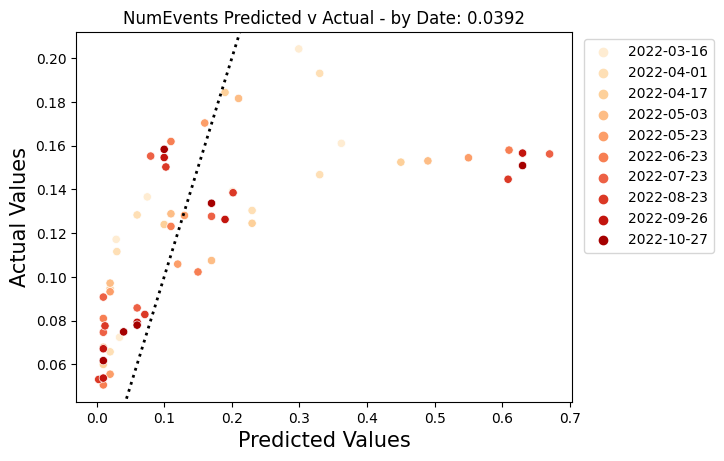

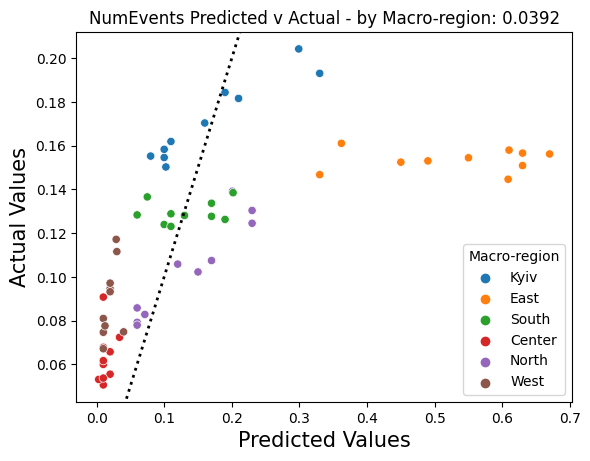




NumEvents_VerbalCooperation

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.020
Model:                            OLS   Adj. R-squared:                  0.003
Method:                 Least Squares   F-statistic:                     1.169
Date:                Wed, 12 Apr 2023   Prob (F-statistic):              0.284
Time:                        09:46:53   Log-Likelihood:                 16.315
No. Observations:                  60   AIC:                            -28.63
Df Residuals:                      58   BIC:                            -24.44
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.094

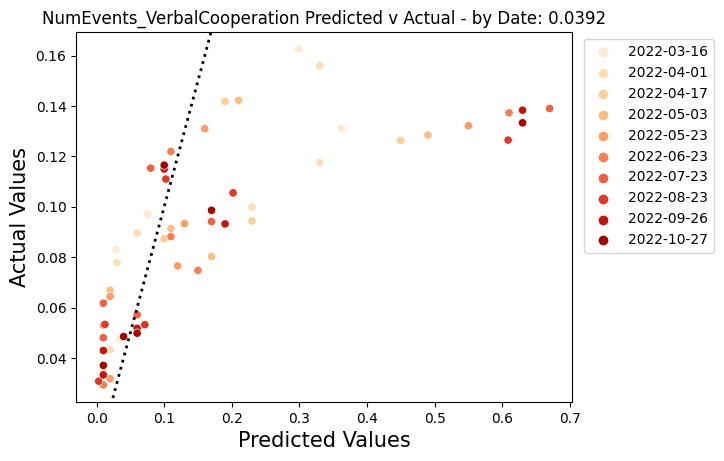

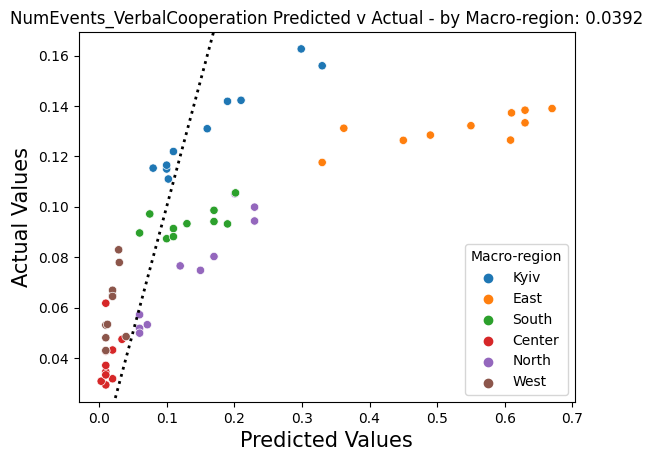




NumEvents_MateriallCooperation

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.034
Model:                            OLS   Adj. R-squared:                  0.017
Method:                 Least Squares   F-statistic:                     2.035
Date:                Wed, 12 Apr 2023   Prob (F-statistic):              0.159
Time:                        09:46:54   Log-Likelihood:                 16.751
No. Observations:                  60   AIC:                            -29.50
Df Residuals:                      58   BIC:                            -25.31
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.

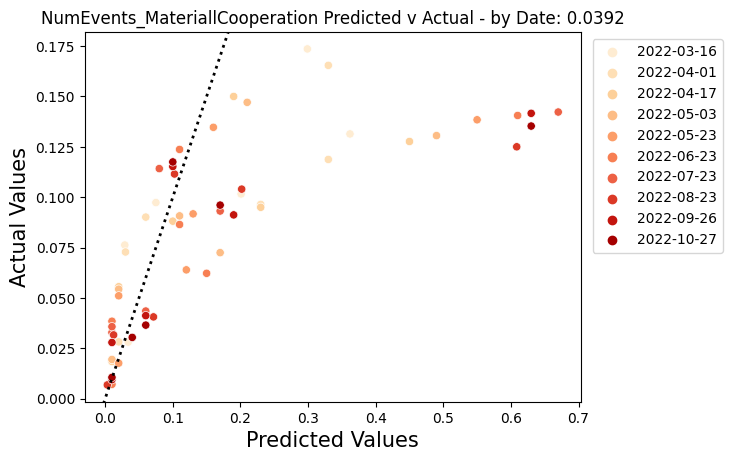

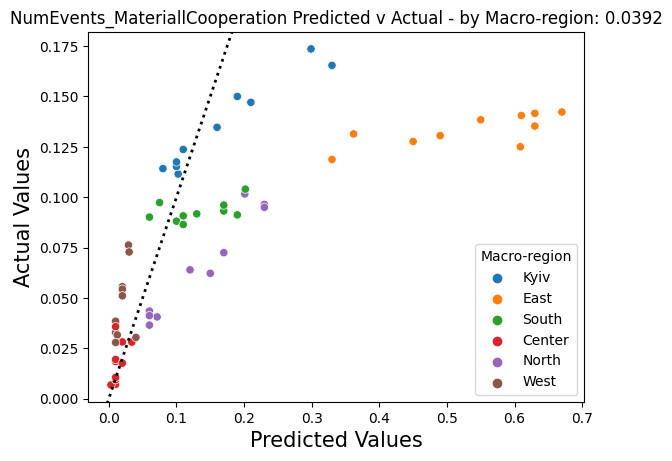




NumEvents_VerbalConflict

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.045
Model:                            OLS   Adj. R-squared:                  0.029
Method:                 Least Squares   F-statistic:                     2.740
Date:                Wed, 12 Apr 2023   Prob (F-statistic):              0.103
Time:                        09:46:55   Log-Likelihood:                 17.101
No. Observations:                  60   AIC:                            -30.20
Df Residuals:                      58   BIC:                            -26.01
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0959  

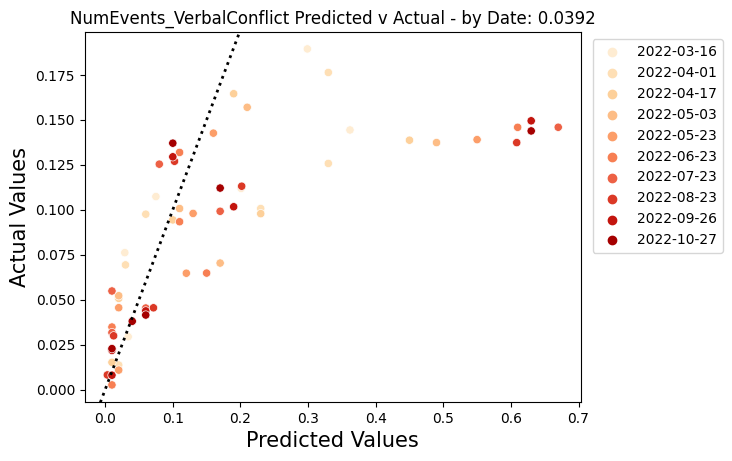

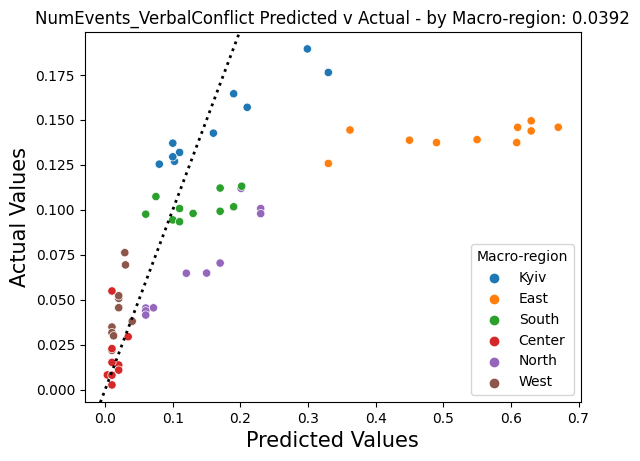




NumEvents_MaterialConflict

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.061
Model:                            OLS   Adj. R-squared:                  0.045
Method:                 Least Squares   F-statistic:                     3.787
Date:                Wed, 12 Apr 2023   Prob (F-statistic):             0.0565
Time:                        09:46:57   Log-Likelihood:                 17.614
No. Observations:                  60   AIC:                            -31.23
Df Residuals:                      58   BIC:                            -27.04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0603

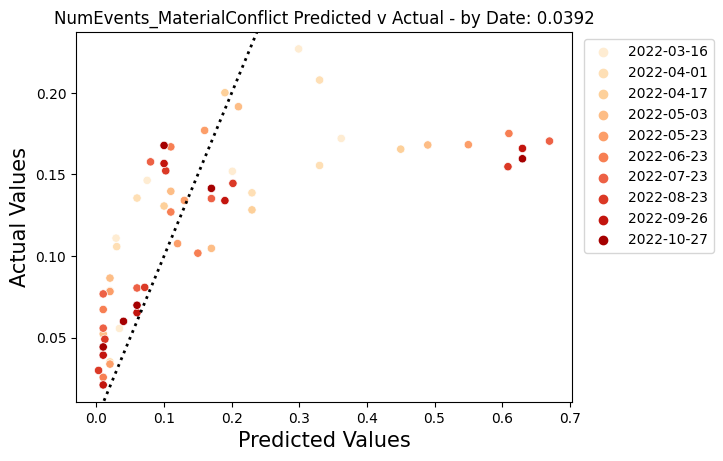

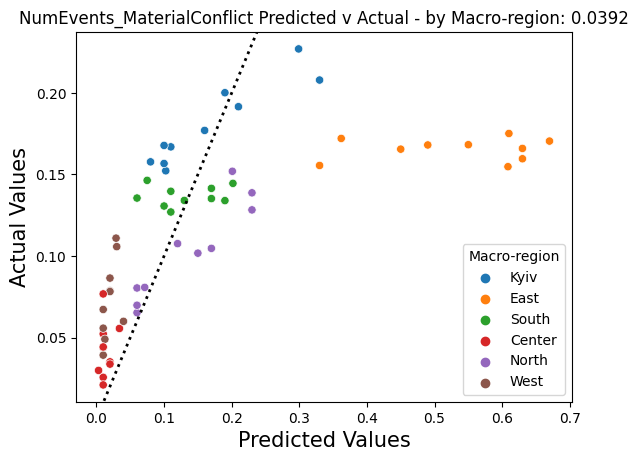




absGoldstein

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.041
Model:                            OLS   Adj. R-squared:                  0.025
Method:                 Least Squares   F-statistic:                     2.507
Date:                Wed, 12 Apr 2023   Prob (F-statistic):              0.119
Time:                        09:46:58   Log-Likelihood:                 16.986
No. Observations:                  60   AIC:                            -29.97
Df Residuals:                      58   BIC:                            -25.78
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0070      0.104   

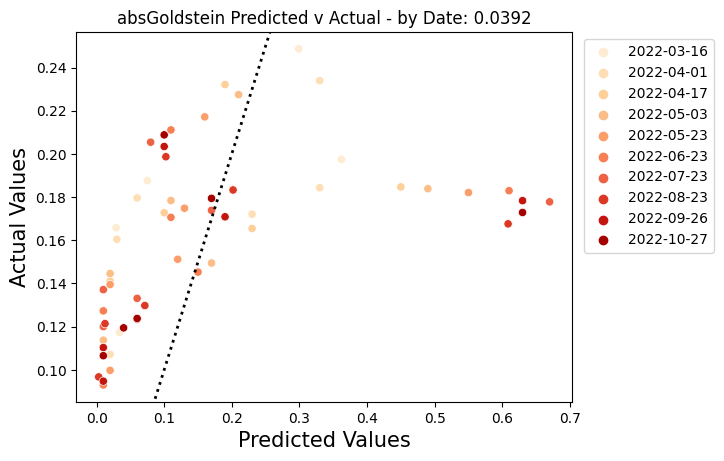

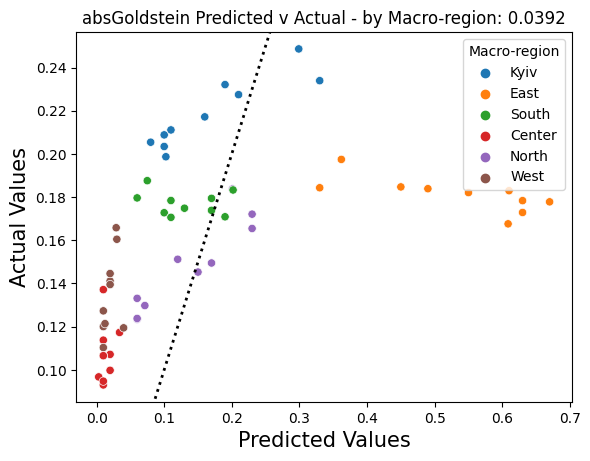




totalPosGoldstein

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.024
Model:                            OLS   Adj. R-squared:                  0.007
Method:                 Least Squares   F-statistic:                     1.401
Date:                Wed, 12 Apr 2023   Prob (F-statistic):              0.241
Time:                        09:46:59   Log-Likelihood:                 16.432
No. Observations:                  60   AIC:                            -28.86
Df Residuals:                      58   BIC:                            -24.68
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0631      0.0

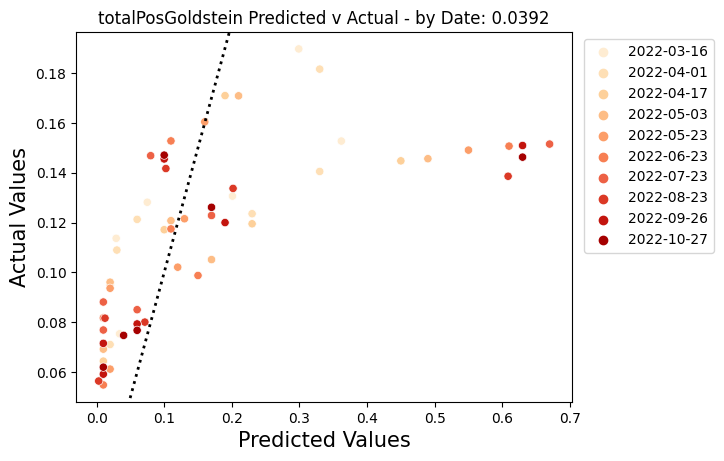

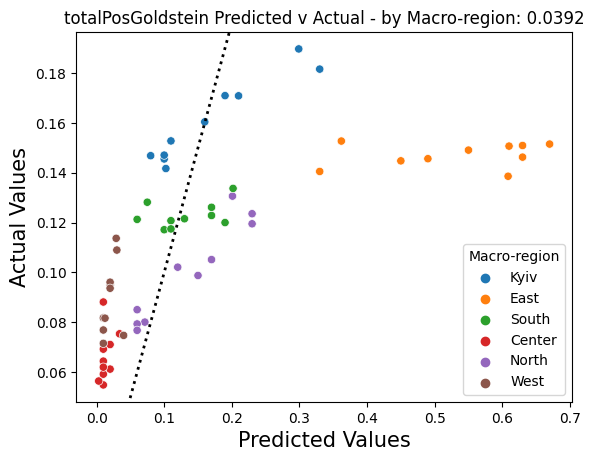




absAvgTone

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.039
Model:                            OLS   Adj. R-squared:                  0.023
Method:                 Least Squares   F-statistic:                     2.369
Date:                Wed, 12 Apr 2023   Prob (F-statistic):              0.129
Time:                        09:47:00   Log-Likelihood:                 16.917
No. Observations:                  60   AIC:                            -29.83
Df Residuals:                      58   BIC:                            -25.65
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0181      0.100     

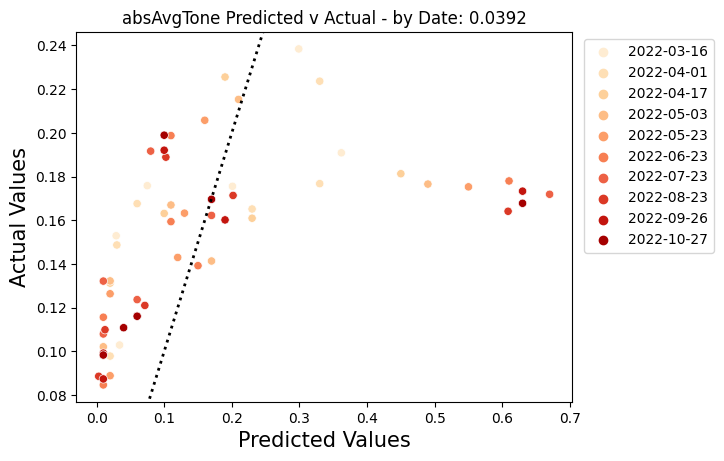

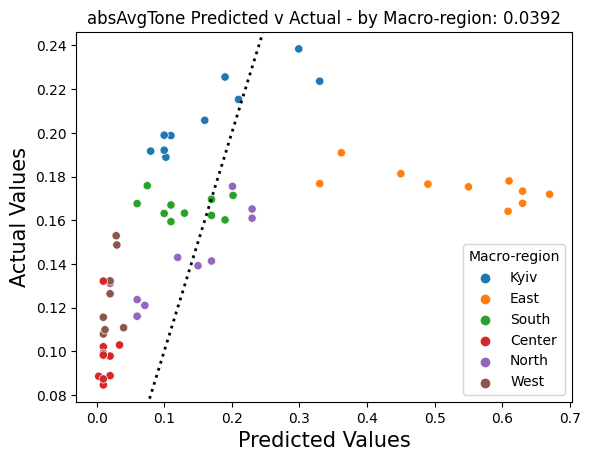

In [12]:
# build regression model for each GDELT events variable
#plt.figure(figsize=(5,3))
for column in log_df.columns[1:9]:
    Y = unhcr_df['Percent']
    X = log_df[column]
    model = sm.OLS(np.array(Y.astype(float)), sm.add_constant(np.array(X.astype(float))))
    fit = model.fit()
    print(column + "\n")
    print(fit.summary())
    print("\n")
    print('R-squared: ', fit.rsquared)
    print("\n")
    
    # predictions vs actual values plot, colored by date
    predictions = fit.predict(pd.concat([unhcr_df['Percent'], log_df[column]], axis=1))
    plt.title(column + " Predicted v Actual - by Date: " + str('%.4f'%(results.rsquared)))
    plt.xlabel('Predicted Values', fontsize=15)
    plt.ylabel('Actual Values', fontsize=15)
    #plt.scatter(predictions, unhcr_df['Percent'], c=unhcr_df.date_to, cmap='OrRd')
    sns.scatterplot(x=unhcr_df['Percent'], y=predictions, hue=unhcr_df['date_to'].dt.date, palette='OrRd') # add style=unhcr_df['Macro-region'] for shape by Macro-region or vice versa
    plt.legend(bbox_to_anchor=(1.3, 1), loc='upper right')
    xpoints = ypoints = plt.xlim()
    plt.plot(xpoints, ypoints, linestyle = 'dotted', color='k', lw=2, scalex=False, scaley=False)
    plt.show()
    
    # predictions vs actual values plot, colored by Macro-region
    plt.title(column + " Predicted v Actual - by Macro-region: " + str('%.4f'%(results.rsquared)))
    plt.xlabel('Predicted Values', fontsize=15)
    plt.ylabel('Actual Values', fontsize=15)
#     colors = {'Kyiv':'red', 'East':'green', 'South':'blue', 'Center':'yellow', 'North':'purple', 'West':'orange'}
#     plt.scatter(predictions, unhcr_df['Percent'], c=unhcr_df['Macro-region'].map(colors))
    # legent only shows kyiv???
    #plt.legend(labels=unhcr_df['Macro-region'])
    sns.scatterplot(x=unhcr_df['Percent'], y=predictions, hue=unhcr_df['Macro-region'])
    xpoints = ypoints = plt.xlim()
    plt.plot(xpoints, ypoints, linestyle = 'dotted', color='k', lw=2, scalex=False, scaley=False)
    plt.show()
    
    print("\n\n")

# Lag/Lead

In [13]:
# for each lag/lead interval, aggregate by date range and add to df with all lag/lead data
lag_df = pd.DataFrame(columns=['Macro-region',
                                 'NumEvents',
                                 'NumEvents_VerbalCooperation',
                                 'NumEvents_MateriallCooperation',
                                 'NumEvents_VerbalConflict',
                                 'NumEvents_MaterialConflict',
                                 'absGoldstein',
                                 'totalNegGoldstein',
                                 'totalPosGoldstein',
                                 'absAvgTone',
                                 'totalPosTone',
                                 'totalNegTone', ])
for i in range(-24,25):
    ranges = list(intervals.itertuples(index=False, name=None))
    for drange in ranges:
        lag = timedelta(days = i)
        events_date_range = gdelt_df[(gdelt_df['date'] >= drange[0] + lag) & (gdelt_df['date'] < drange[1] + lag)]
        events_date_range = events_date_range.groupby('Macro-region').mean()
        events_date_range = events_date_range.reset_index()
        events_date_range['date_from'] = drange[0]
        events_date_range['date_to'] = drange[1]
        events_date_range['lag'] = int(i)
        frames = [lag_df, events_date_range]
        lag_df = pd.concat(frames)

In [14]:
len(final_df) * 49 # 49 lag values in [-24,24]

2940

In [15]:
len(lag_df)

2940

In [16]:
# create regression models, add r squared for each lag and variable to table
r_squared_df = pd.DataFrame(columns=['lag',
                                 'variable',
                                 'r_squared'])
for i in range(-24,25):
    temp_df = lag_df[lag_df['lag']==i]
    for column in lag_df.columns[1:12]:
        Y = unhcr_df['Percent']
        X = temp_df[column]
        model = sm.OLS(np.array(Y.astype(float)), sm.add_constant(np.array(X.astype(float))))
        fit = model.fit()
        r_squared_df.loc[len(r_squared_df.index)] = [i, column, fit.rsquared]
        
#r_squared_df.set_index(['lag', 'variable'], inplace=True)

In [17]:
len(r_squared_df)

539

In [18]:
11*49 # 49 lag values and 11 variables each

539

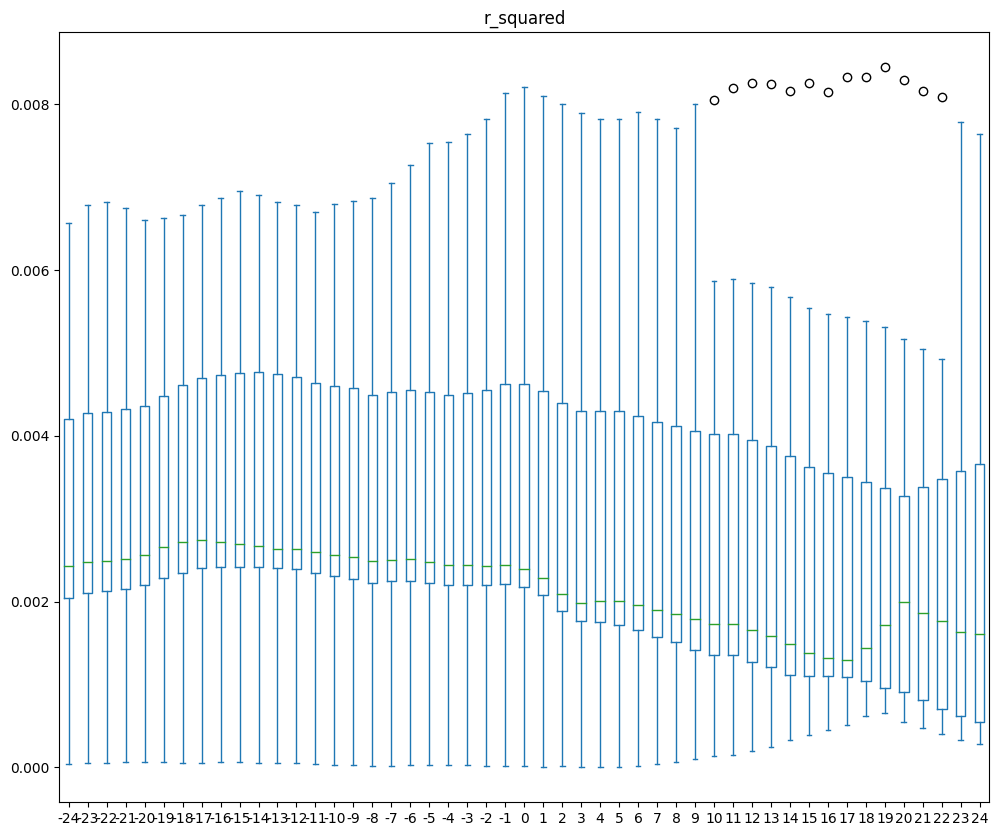

In [19]:
ax = r_squared_df.plot.box(by="lag", figsize=(12, 10))
#plt.xticks(fontsize=8, rotation=90)

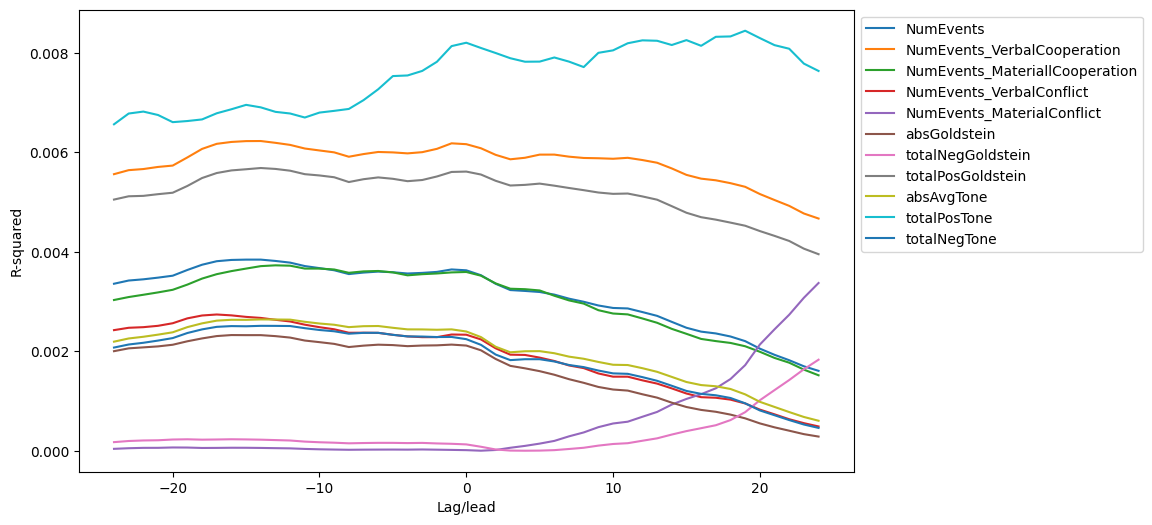

In [20]:
plt.figure(figsize=(10,6))
for column in lag_df.columns[1:12]:
    temp_df = r_squared_df[r_squared_df['variable']==column]
    plt.plot(temp_df['lag'], temp_df['r_squared'], label=column)
   
plt.legend(bbox_to_anchor=(1, 1))
plt.xlabel("Lag/lead")
plt.ylabel("R-squared")
plt.show()

### Modeling with Dummy Variables

NumEvents

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.880
Model:                            OLS   Adj. R-squared:                  0.867
Method:                 Least Squares   F-statistic:                     65.02
Date:                Wed, 12 Apr 2023   Prob (F-statistic):           1.11e-22
Time:                        09:47:09   Log-Likelihood:                 79.423
No. Observations:                  60   AIC:                            -144.8
Df Residuals:                      53   BIC:                            -130.2
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
x1         -2.831e-05   1.43e-05     -1.9

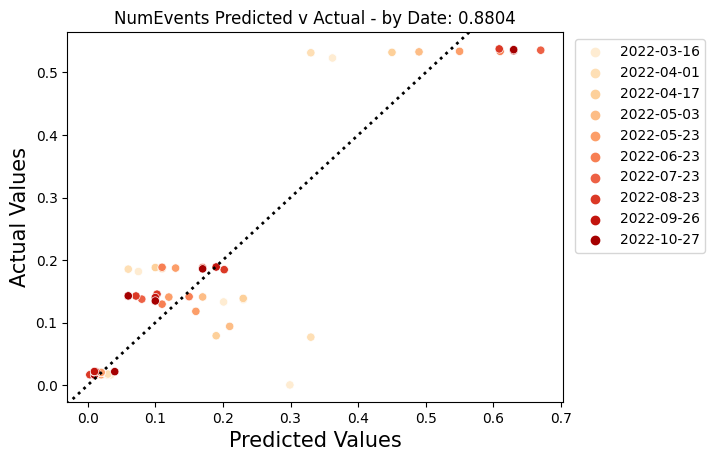

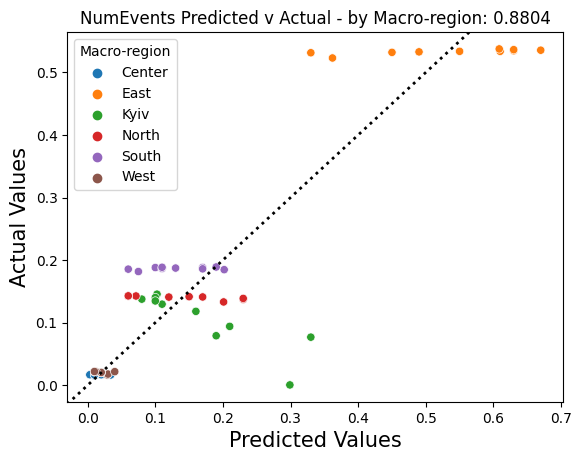




NumEvents_VerbalCooperation

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.881
Model:                            OLS   Adj. R-squared:                  0.867
Method:                 Least Squares   F-statistic:                     65.30
Date:                Wed, 12 Apr 2023   Prob (F-statistic):           1.01e-22
Time:                        09:47:10   Log-Likelihood:                 79.537
No. Observations:                  60   AIC:                            -145.1
Df Residuals:                      53   BIC:                            -130.4
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
x1         -5.109e-0

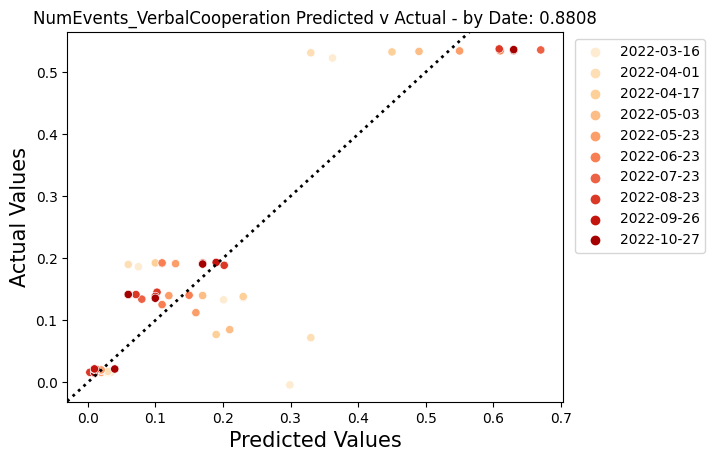

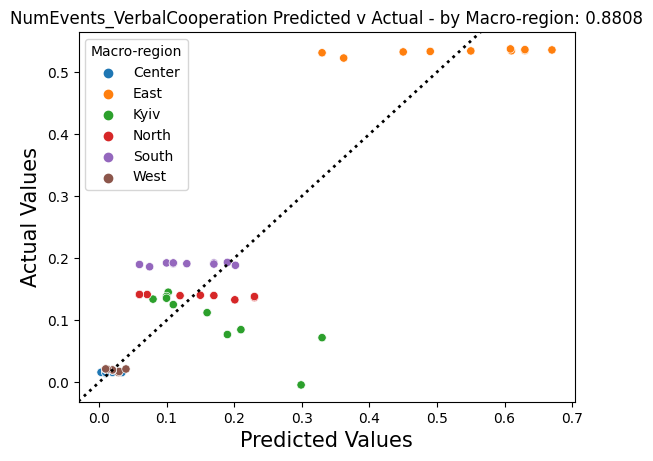




NumEvents_MateriallCooperation

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.880
Model:                            OLS   Adj. R-squared:                  0.867
Method:                 Least Squares   F-statistic:                     64.98
Date:                Wed, 12 Apr 2023   Prob (F-statistic):           1.13e-22
Time:                        09:47:11   Log-Likelihood:                 79.405
No. Observations:                  60   AIC:                            -144.8
Df Residuals:                      53   BIC:                            -130.2
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
x1            -0.

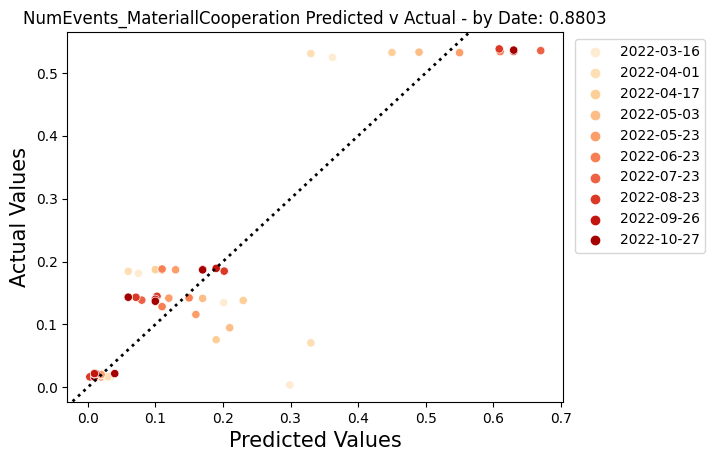

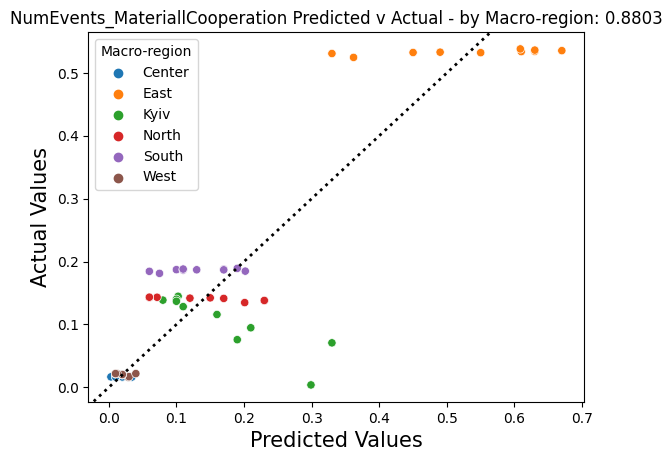




NumEvents_VerbalConflict

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.879
Model:                            OLS   Adj. R-squared:                  0.866
Method:                 Least Squares   F-statistic:                     64.46
Date:                Wed, 12 Apr 2023   Prob (F-statistic):           1.36e-22
Time:                        09:47:12   Log-Likelihood:                 79.196
No. Observations:                  60   AIC:                            -144.4
Df Residuals:                      53   BIC:                            -129.7
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
x1            -0.0002  

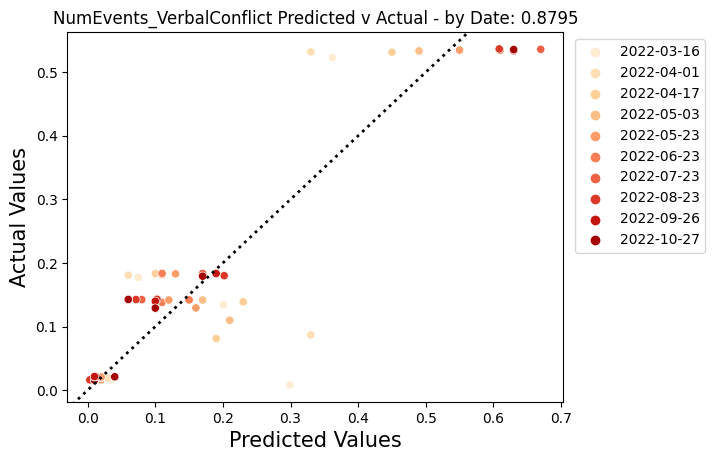

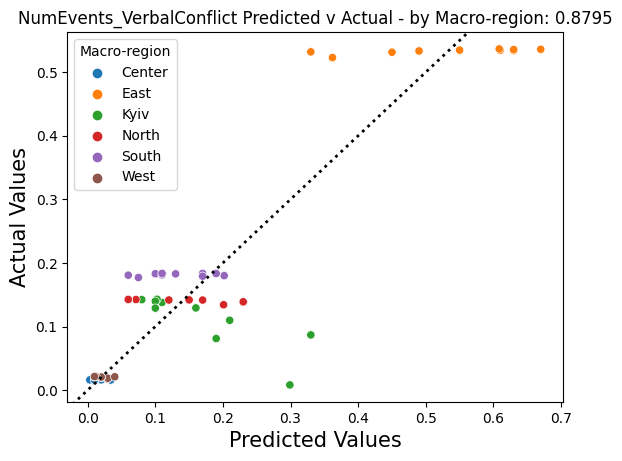




NumEvents_MaterialConflict

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.879
Model:                            OLS   Adj. R-squared:                  0.866
Method:                 Least Squares   F-statistic:                     64.40
Date:                Wed, 12 Apr 2023   Prob (F-statistic):           1.39e-22
Time:                        09:47:13   Log-Likelihood:                 79.169
No. Observations:                  60   AIC:                            -144.3
Df Residuals:                      53   BIC:                            -129.7
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
x1            -0.0002

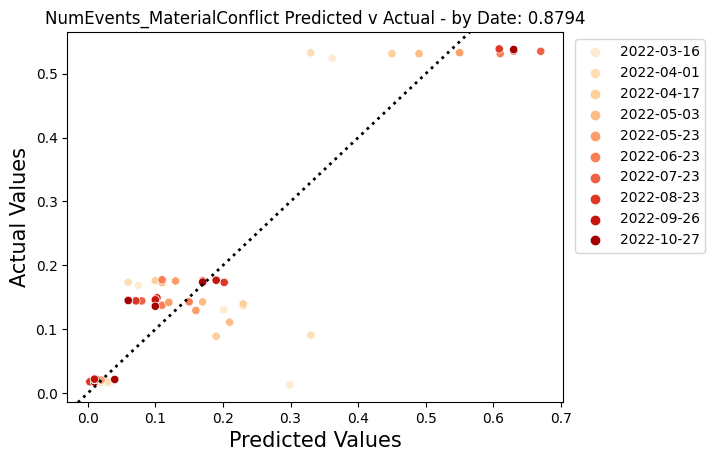

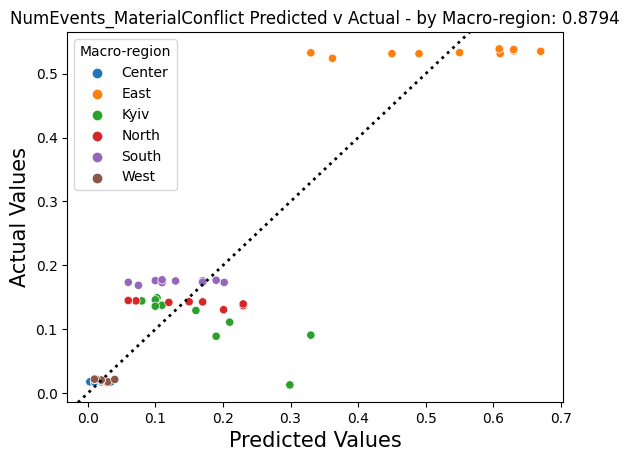




absGoldstein

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.880
Model:                            OLS   Adj. R-squared:                  0.867
Method:                 Least Squares   F-statistic:                     64.91
Date:                Wed, 12 Apr 2023   Prob (F-statistic):           1.16e-22
Time:                        09:47:14   Log-Likelihood:                 79.378
No. Observations:                  60   AIC:                            -144.8
Df Residuals:                      53   BIC:                            -130.1
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
x1         -6.613e-06   3.38e-06   

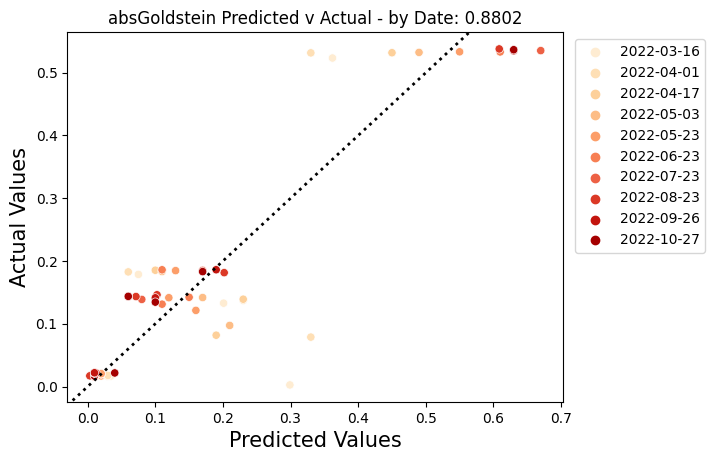

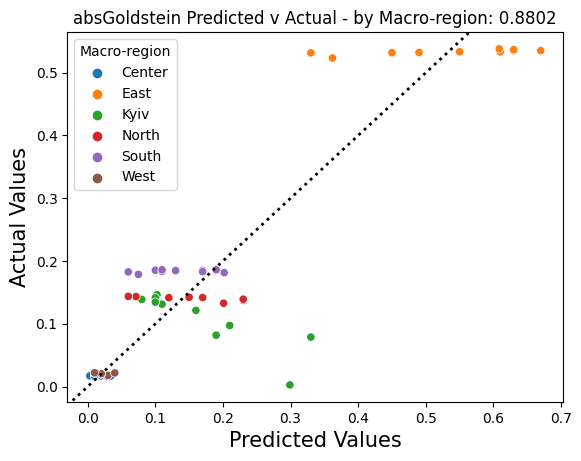




totalNegGoldstein

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.879
Model:                            OLS   Adj. R-squared:                  0.866
Method:                 Least Squares   F-statistic:                     64.44
Date:                Wed, 12 Apr 2023   Prob (F-statistic):           1.37e-22
Time:                        09:47:15   Log-Likelihood:                 79.186
No. Observations:                  60   AIC:                            -144.4
Df Residuals:                      53   BIC:                            -129.7
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
x1          1.322e-05   7.09e-

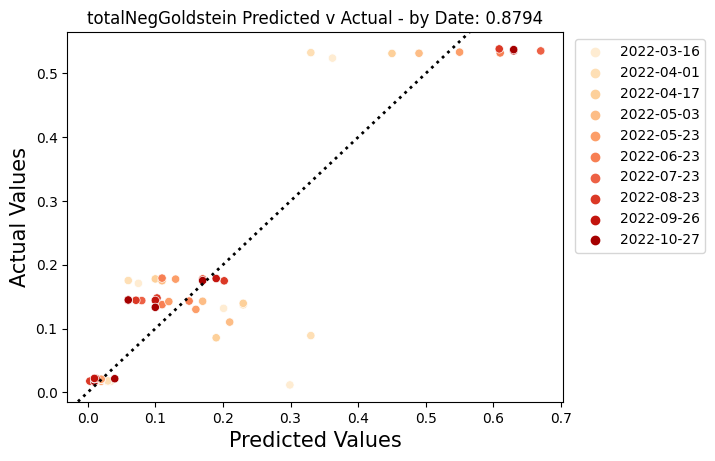

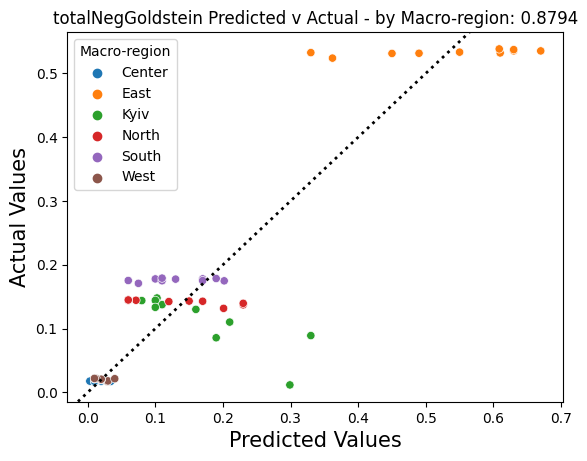




totalPosGoldstein

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.881
Model:                            OLS   Adj. R-squared:                  0.867
Method:                 Least Squares   F-statistic:                     65.28
Date:                Wed, 12 Apr 2023   Prob (F-statistic):           1.02e-22
Time:                        09:47:16   Log-Likelihood:                 79.527
No. Observations:                  60   AIC:                            -145.1
Df Residuals:                      53   BIC:                            -130.4
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
x1         -1.299e-05    6.4e-

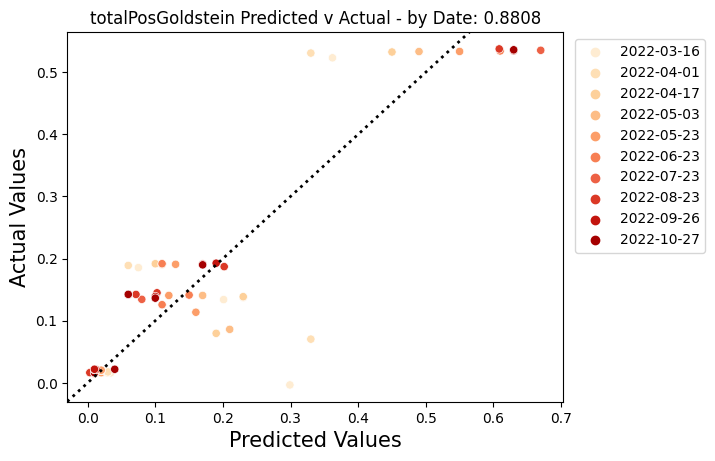

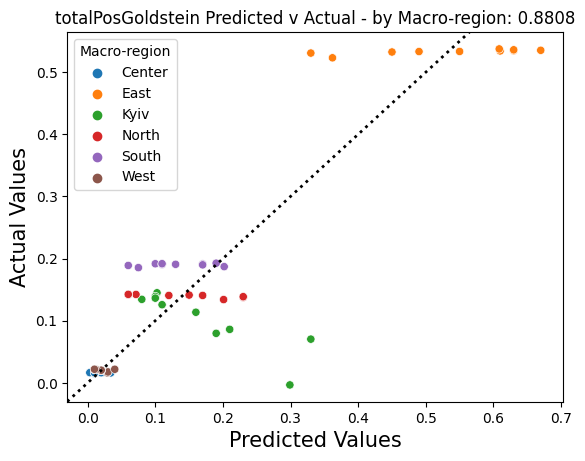




absAvgTone

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.880
Model:                            OLS   Adj. R-squared:                  0.867
Method:                 Least Squares   F-statistic:                     64.89
Date:                Wed, 12 Apr 2023   Prob (F-statistic):           1.17e-22
Time:                        09:47:18   Log-Likelihood:                 79.371
No. Observations:                  60   AIC:                            -144.7
Df Residuals:                      53   BIC:                            -130.1
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
x1          -7.33e-06   3.75e-06     

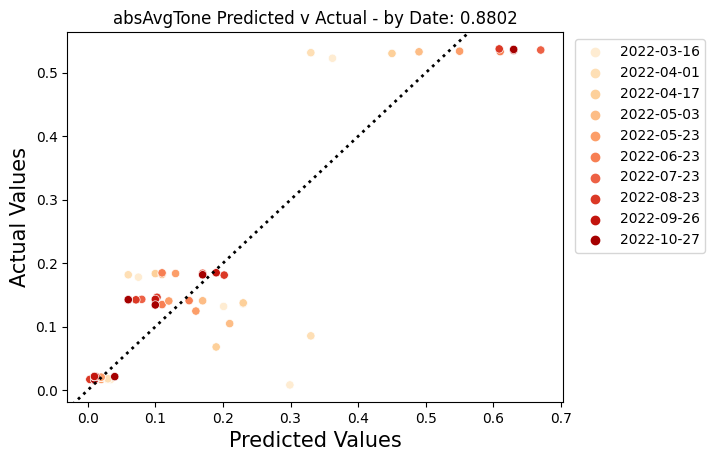

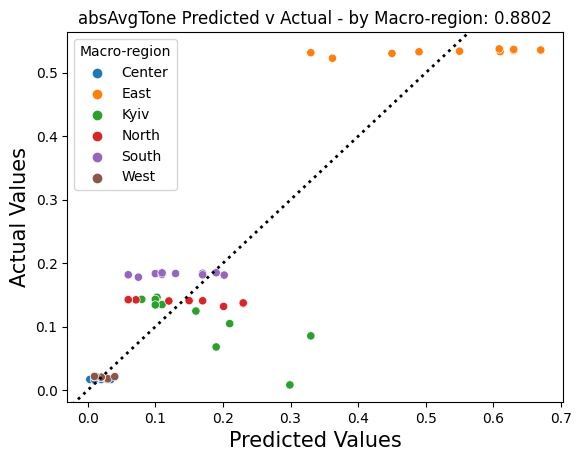




totalPosTone

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.880
Model:                            OLS   Adj. R-squared:                  0.866
Method:                 Least Squares   F-statistic:                     64.51
Date:                Wed, 12 Apr 2023   Prob (F-statistic):           1.33e-22
Time:                        09:47:19   Log-Likelihood:                 79.217
No. Observations:                  60   AIC:                            -144.4
Df Residuals:                      53   BIC:                            -129.8
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
x1            -0.0004      0.000   

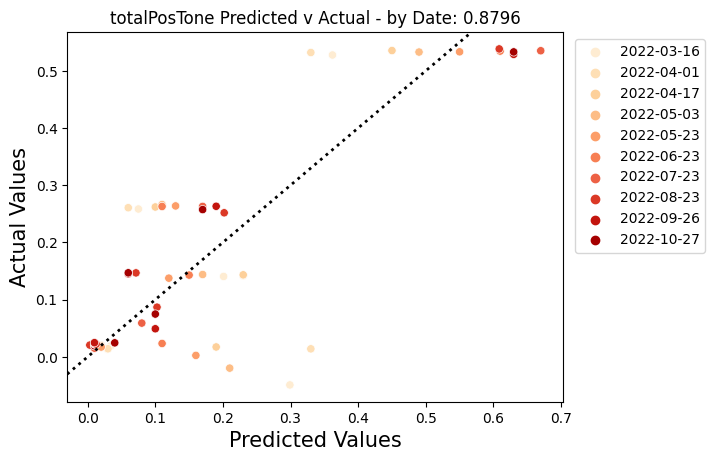

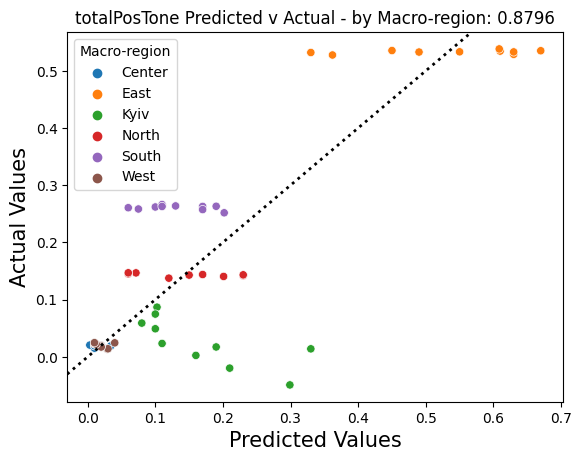




totalNegTone

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.880
Model:                            OLS   Adj. R-squared:                  0.867
Method:                 Least Squares   F-statistic:                     64.86
Date:                Wed, 12 Apr 2023   Prob (F-statistic):           1.18e-22
Time:                        09:47:20   Log-Likelihood:                 79.359
No. Observations:                  60   AIC:                            -144.7
Df Residuals:                      53   BIC:                            -130.1
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
x1            7.4e-06    3.8e-06   

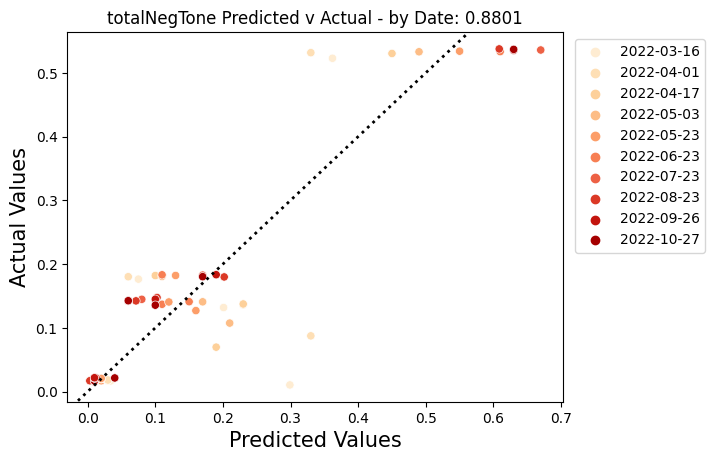

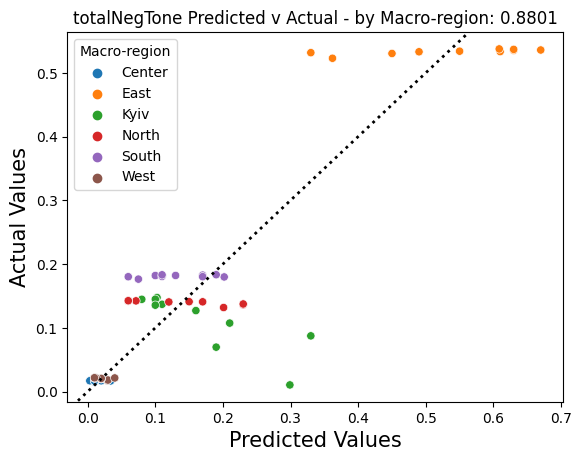

In [21]:
rsquared_list = []

# build regression model for each GDELT events variable
for column in final_df.columns[1:12]:
    Y = np.asarray(unhcr_df['Percent'].astype(float))
    X = np.asarray(final_df[[column]].astype(float))
    
    # build model without dummy variables
    #X = sm.add_constant(X)
    
    
    # dummy variables for macroregion - drop_first = True
    X = np.concatenate([X, pd.get_dummies(unhcr_df['Macro-region'])], axis=1)
    
    model = sm.OLS(Y, X)
    #Fitting model
    results = model.fit()
    #Saving the r_square value
    rsquared_list.append(results.rsquared)
    
    print(column + "\n")
    print(results.summary())
    print("\n")
    print('R-squared: ', results.rsquared)
    print("\n")
    
    # predictions vs actual values plot, colored by date
    predictions = results.predict(pd.concat([final_df[[column]], pd.get_dummies(unhcr_df['Macro-region'])], axis=1))
    plt.title(column + " Predicted v Actual - by Date: " + str('%.4f'%(results.rsquared)))
    plt.xlabel('Predicted Values', fontsize=15)
    plt.ylabel('Actual Values', fontsize=15)
    #plt.scatter(predictions, unhcr_df['Percent'], c=unhcr_df.date_to, cmap='OrRd')
    sns.scatterplot(x=unhcr_df['Percent'], y=predictions, hue=unhcr_df['date_to'].dt.date, palette='OrRd') # add style=unhcr_df['Macro-region'] for shape by Macro-region or vice versa
    plt.legend(bbox_to_anchor=(1.3, 1), loc='upper right')
    xpoints = ypoints = plt.xlim()
    plt.plot(xpoints, ypoints, linestyle = 'dotted', color='k', lw=2, scalex=False, scaley=False)
    plt.show()
    
    # predictions vs actual values plot, colored by Macro-region
    plt.title(column + " Predicted v Actual - by Macro-region: " + str('%.4f'%(results.rsquared)))
    plt.xlabel('Predicted Values', fontsize=15)
    plt.ylabel('Actual Values', fontsize=15)
#     colors = {'Kyiv':'red', 'East':'green', 'South':'blue', 'Center':'yellow', 'North':'purple', 'West':'orange'}
#     plt.scatter(predictions, unhcr_df['Percent'], c=unhcr_df['Macro-region'].map(colors))
#     plt.legend(['Kyiv','East','South','Center','North','West'])
    sns.scatterplot(x=unhcr_df['Percent'], y=predictions, hue=unhcr_df['Macro-region'])
    xpoints = ypoints = plt.xlim()
    plt.plot(xpoints, ypoints, linestyle = 'dotted', color='k', lw=2, scalex=False, scaley=False)
    plt.show()
    
    print("\n\n")

### Lag/lead with dummy variables

In [22]:
# for each lag/lead interval, aggregate by date range and add to df with all lag/lead data
lag_df = pd.DataFrame(columns=['Macro-region',
                                 'NumEvents',
                                 'NumEvents_VerbalCooperation',
                                 'NumEvents_MateriallCooperation',
                                 'NumEvents_VerbalConflict',
                                 'NumEvents_MaterialConflict',
                                 'absGoldstein',
                                 'totalNegGoldstein',
                                 'totalPosGoldstein',
                                 'absAvgTone',
                                 'totalPosTone',
                                 'totalNegTone', ])
for i in range(-24,25):
    ranges = list(intervals.itertuples(index=False, name=None))
    for drange in ranges:
        lag = timedelta(days = i)
        events_date_range = gdelt_df[(gdelt_df['date'] >= drange[0] + lag) & (gdelt_df['date'] < drange[1] + lag)]
        events_date_range = events_date_range.groupby('Macro-region').mean()
        events_date_range = events_date_range.reset_index()
        events_date_range['date_from'] = drange[0]
        events_date_range['date_to'] = drange[1]
        events_date_range['lag'] = int(i)
        frames = [lag_df, events_date_range]
        lag_df = pd.concat(frames)

In [23]:
# create regression models, add r squared for each lag and variable to table
r_squared_df_dummy = pd.DataFrame(columns=['lag',
                                 'variable',
                                 'r_squared'])
for i in range(-24,25):
    temp_df = lag_df[lag_df['lag']==i]
    for column in lag_df.columns[1:12]:
        Y = np.asarray(unhcr_df['Percent'].astype(float))
        X = np.asarray(final_df[[column]].astype(float))
        X = np.concatenate([X, pd.get_dummies(unhcr_df['Macro-region'])], axis=1)
        model = sm.OLS(Y, X)
        fit = model.fit()
        r_squared_df_dummy.loc[len(r_squared_df_dummy.index)] = [i, column, fit.rsquared]
        
#r_squared_df.set_index(['lag', 'variable'], inplace=True)

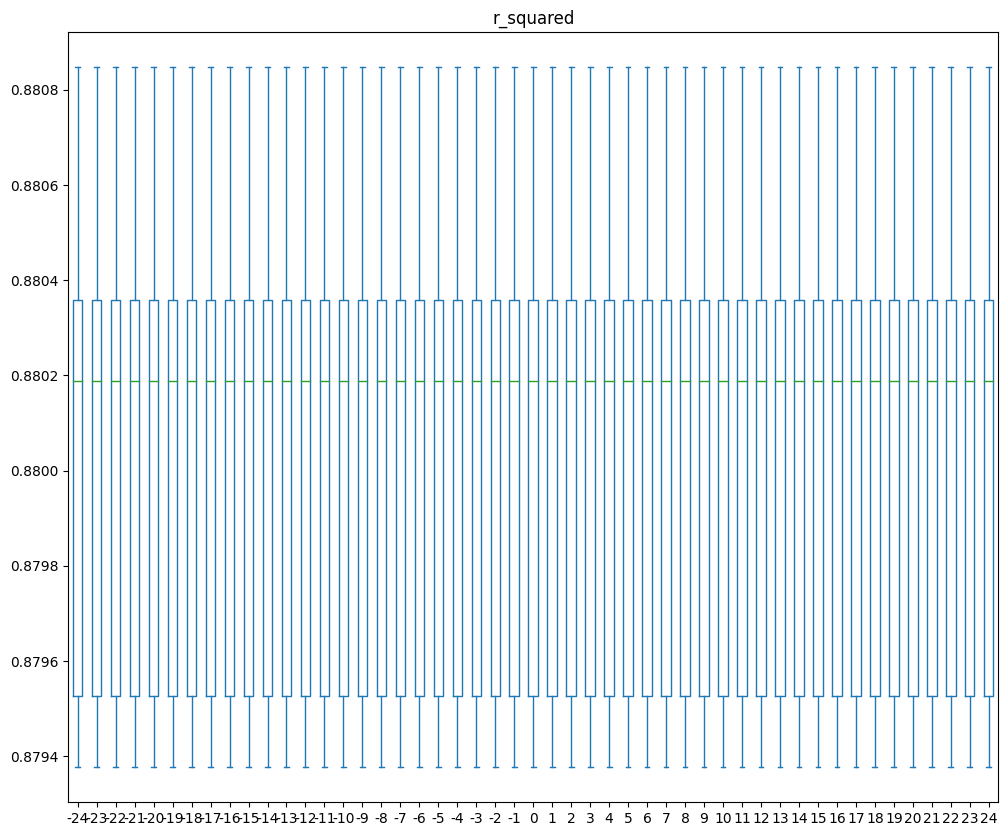

In [24]:
# Create boxplots capturing how r-squared values vary across lag/lead values
ax = r_squared_df_dummy.plot.box(by="lag", figsize=(12, 10))

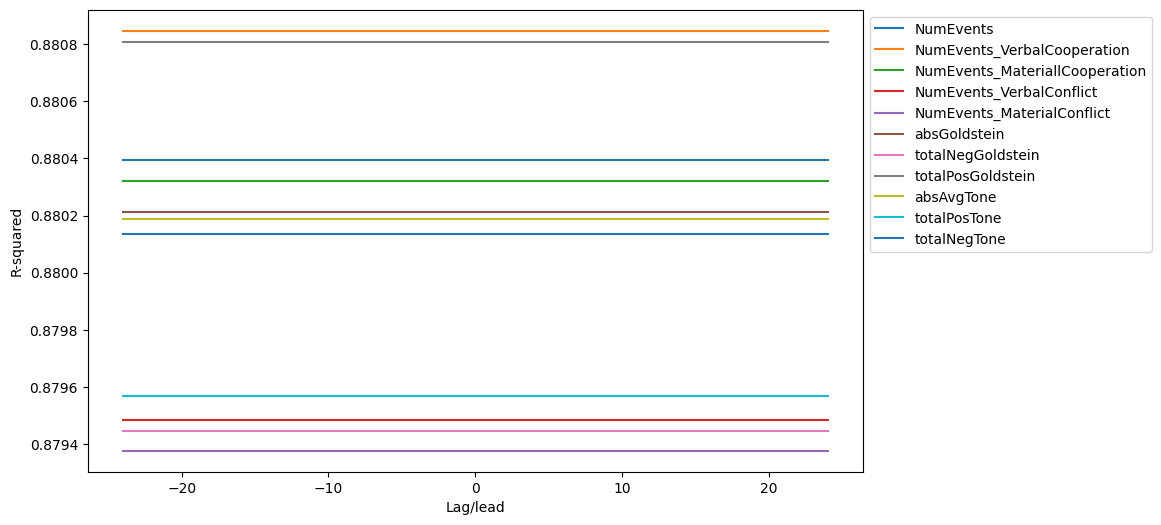

In [25]:
# Lag/lead line plot: how each variable varies across lag values
plt.figure(figsize=(10,6))
for column in lag_df.columns[1:12]:
    temp_df = r_squared_df_dummy[r_squared_df_dummy['variable']==column]
    plt.plot(temp_df['lag'], temp_df['r_squared'], label=column)
   
plt.legend(bbox_to_anchor=(1, 1))
plt.xlabel("Lag/lead")
plt.ylabel("R-squared")
plt.show()